In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import re
import pickle
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from glob import glob
from copy import deepcopy
from statannotations.Annotator import Annotator
from sklearn.metrics import auc, roc_auc_score, roc_curve
from scipy.stats import pearsonr, chi2_contingency, linregress, ranksums, spearmanr, ttest_ind, ttest_rel
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn3
import matplotlib as mpl
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import font_manager

In [3]:
label_dict = {'Normal':0,'Tumor':1}

In [4]:
sns.set_style('ticks')

In [5]:
method_color_dict = {'scMalignantFinder':"#E53935", 'PreCanCell':"#1E88E5", 'ikarus':'#43A047'}

In [6]:
group_colors = [
    "#E53935", "#1E88E5", "#FFB300", "#43A047", "#9B26B0", "#3F51B4", "#02A9F3", "#00BBD3", "#009687", "#8BC34A",
    "#CCDC39", "#FFEB3A", "#FF9800", "#FF5721", "#795447", "#5F7D8B", "#E57272", "#F06192", "#B967C7", "#7985CB",
    "#4EC3F7", "#4CD0E0", "#4CB6AC", "#ADD480", "#DCE674", "#FFF176", "#FFB74C", "#FF8A65", "#A0877F", "#90A4AD",
    "#C52727", "#AC1357", "#6A1A99", "#273492", "#0177BD", "#00838E", "#00685B", "#548B2E", "#9E9D24", "#F8A725",
    "#EE6C00", "#D84314", "#4D332D", "#37464E", "#EE9999", "#F38EB1", "#CD92D8", "#9FA7D9", "#80D3F9", "#7FDEEA",
    "#7FCBC4", "#C5E0A5", "#E5ED9B", "#FFF49D", "#FFCC7F", "#FFAB91", "#BBAAA4", "#B0BEC5", "#FF6E00", "#202020",
    "#1A5E1F", "#311A92", "#FFC006", "#9E9E9E", "#4CAE50", "#6639B7", "#FFD44E", "#DFDFDF", "#80C684", "#9474CC",
    "#FF9F00", "#606060", "#388D3B", "#512CA7", "#FFDF81", "#EDEDED", "#A5D6A6", "#B29DDA", "#FFF8E0", "#F9F9F9"]

In [7]:
sc.settings.set_figure_params(figsize=(5,5), dpi=100, facecolor='white')

In [8]:
os.chdir('/mnt/home/qnyu/workspace/scOmics/malignantModel/multi_tissue')

In [9]:
feature_importance_df = pd.read_csv('./file/feature_importance.LogisticRegression_coefficient.csv', index_col=0)

In [10]:
feature_importance_df.sort_values('importance', ascending=False).iloc[:30]

,coefficient,importance
CA2,-0.073961,0.073961
ANXA10,-0.054162,0.054162
TPPP3,-0.050364,0.050364
DTWD2,-0.048502,0.048502
SLC26A2,-0.047163,0.047163
HEPACAM2,-0.046578,0.046578
MS4A8,-0.046322,0.046322
OCIAD2,0.043685,0.043685
SFTA1P,-0.041304,0.041304
ALDOA,0.040853,0.040853


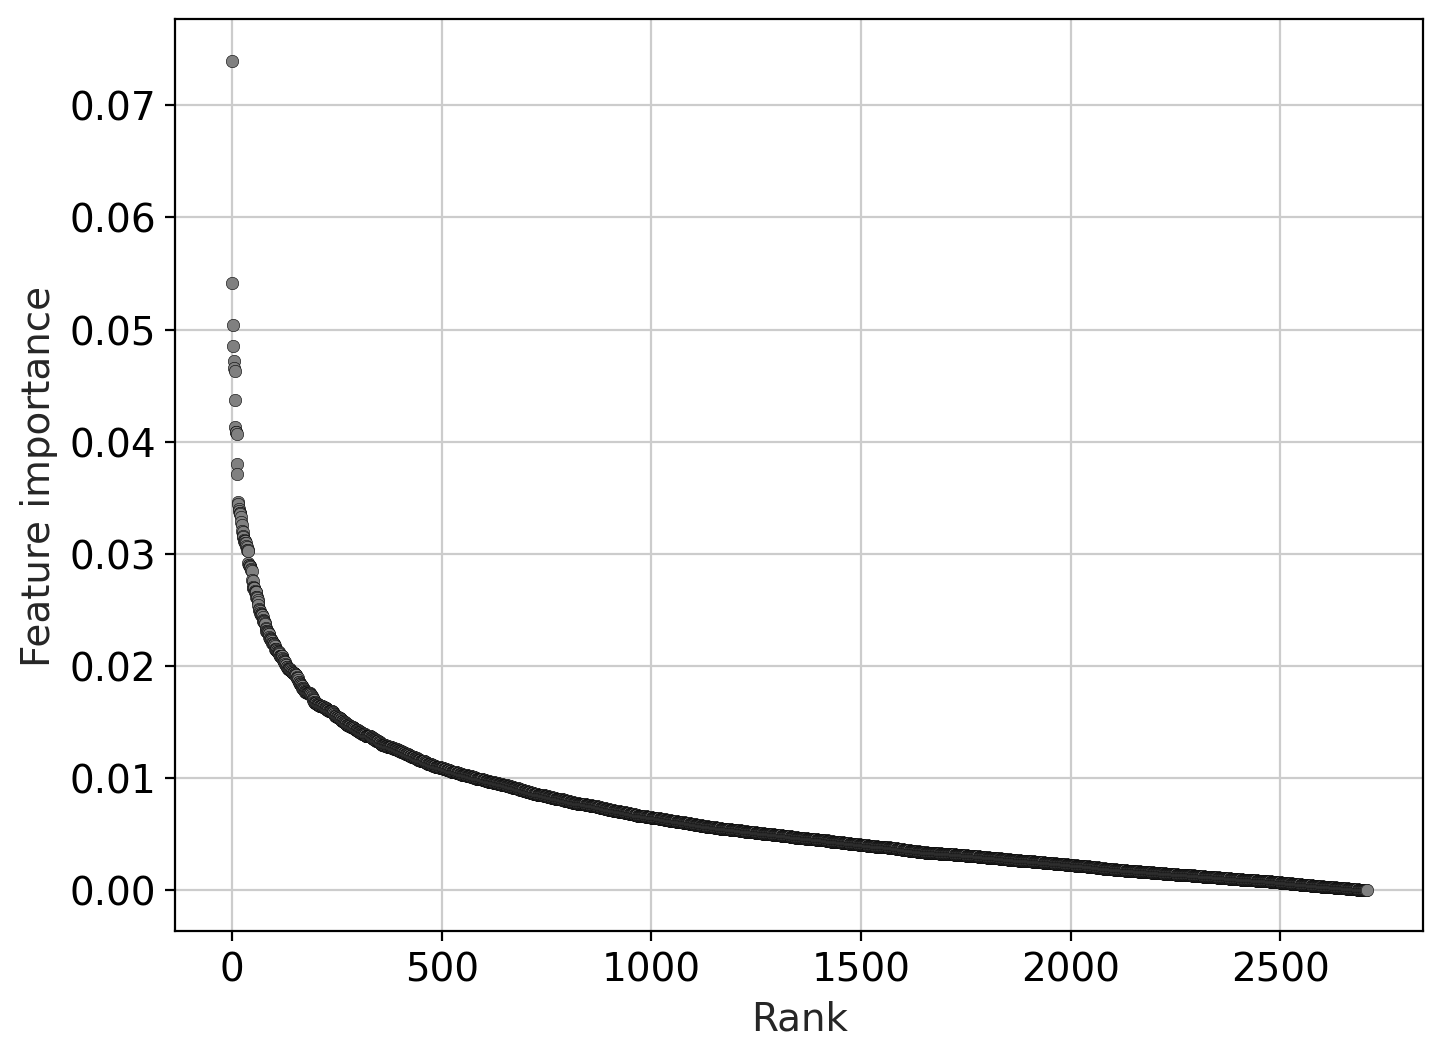

In [11]:
plt.figure(figsize=(8,6))
_ = plt.scatter(x=range(feature_importance_df.shape[0]), y=feature_importance_df['importance'].sort_values(ascending=False), c='grey', 
            s=20, edgecolor='black', linewidth=0.2, rasterized=True)
_ = plt.xlabel('Rank')
_ = plt.ylabel('Feature importance')
plt.savefig('./plot/feature_importance.scatter.pdf', bbox_inches='tight', dpi=1000)

In [12]:
common_up_degs = list(np.loadtxt('./file/deg/common_tumor_up_degs.txt', dtype=str))
common_down_degs = list(np.loadtxt('./file/deg/common_tumor_down_degs.txt', dtype=str))
unique_up_degs = list(np.loadtxt('./file/deg/unique_tumor_up_degs.txt', dtype=str))
unique_down_degs = list(np.loadtxt('./file/deg/unique_tumor_down_degs.txt', dtype=str))

In [13]:
len(unique_down_degs)

1250

In [14]:
filter_common_up_degs = list(set(common_up_degs) & set(feature_importance_df.index))
filter_common_down_degs = list(set(common_down_degs) & set(feature_importance_df.index))
filter_unique_up_degs = list(set(unique_up_degs) & set(feature_importance_df.index))
filter_unique_down_degs = list(set(unique_down_degs) & set(feature_importance_df.index))

In [15]:
np.savetxt('./file/deg/combined_common_tumor_degs.txt', filter_common_up_degs+filter_common_down_degs, fmt='%s')
np.savetxt('./file/deg/combined_uniuqe_tumor_degs.txt', filter_unique_up_degs+filter_unique_down_degs, fmt='%s')

In [16]:
group_importance_df = pd.DataFrame({'Importance':feature_importance_df.loc[filter_common_up_degs+filter_unique_up_degs+filter_common_down_degs+filter_unique_down_degs,'importance'].tolist(), 
                                    'DEG type':['Upregulated\ncommon DEGs']*len(filter_common_up_degs)+['Upregulated\nunique DEGs']*len(filter_unique_up_degs)+['Downregulated\ncommon DEGs']*len(filter_common_down_degs)+['Downregulated\nunique DEGs']*len(filter_unique_down_degs)}, 
                                   index=filter_common_up_degs+filter_unique_up_degs+filter_common_down_degs+filter_unique_down_degs)

In [17]:
pairs = [('Upregulated\ncommon DEGs','Upregulated\nunique DEGs'),('Downregulated\ncommon DEGs','Downregulated\nunique DEGs')]

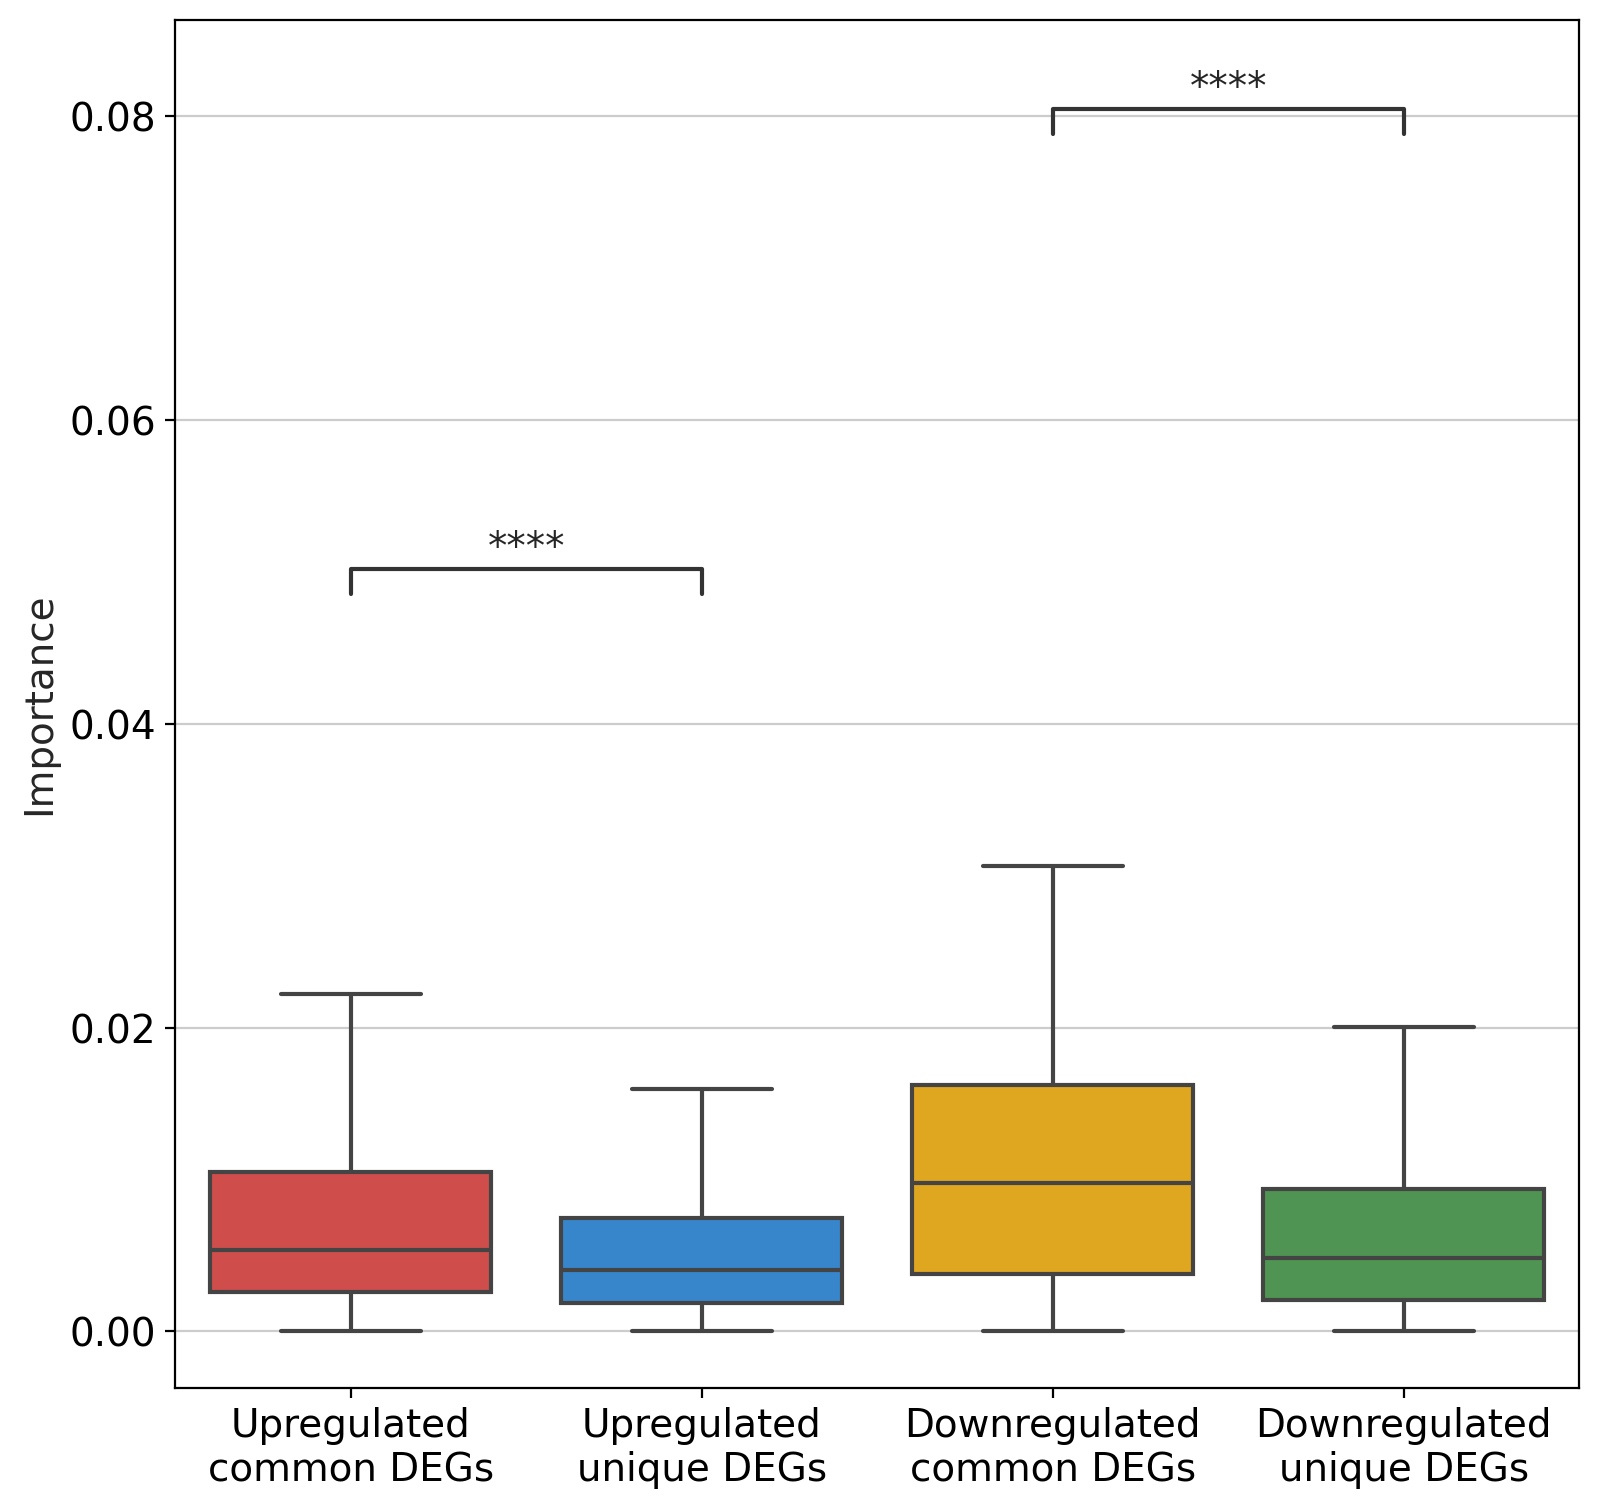

In [18]:
plt.figure(figsize=(9,9))
ax21 = plt.subplot(111)
ax = sns.boxplot(data=group_importance_df, x="DEG type", y='Importance', palette=group_colors, ax=ax21, fliersize=0)
_ = plt.xticks(rotation=0)
annot = Annotator(ax, pairs, data=group_importance_df, x="DEG type", y='Importance', hide_non_significant=True)
annot.configure(test='t-test_ind', text_format='star', verbose=0)
annot.apply_test()
annot.annotate()
_ = plt.xlabel('')
# _ = plt.ylim([-0.01, 0.05])

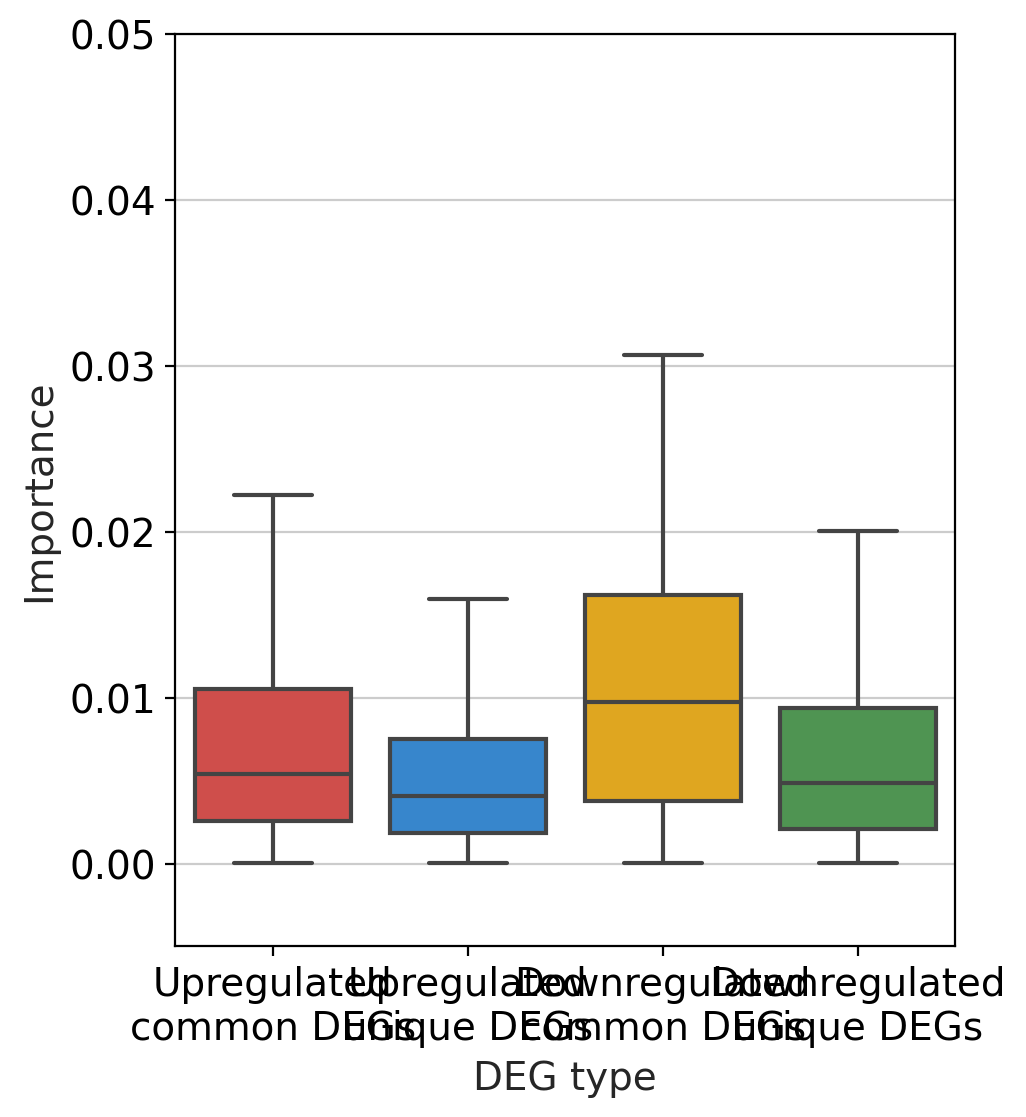

In [19]:
plt.figure(figsize=(5,6))
ax21 = plt.subplot(111)
ax = sns.boxplot(data=group_importance_df, x="DEG type", y='Importance', palette=group_colors, ax=ax21, fliersize=0)
_ = plt.xticks(rotation=0)
_ = plt.ylim([-0.005, 0.05])
plt.savefig('./plot/feature_importance_common_unique_DEGs.boxplot.pdf', bbox_inches='tight', dpi=1000)

In [20]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df['Rank'] = range(feature_importance_df.shape[0])

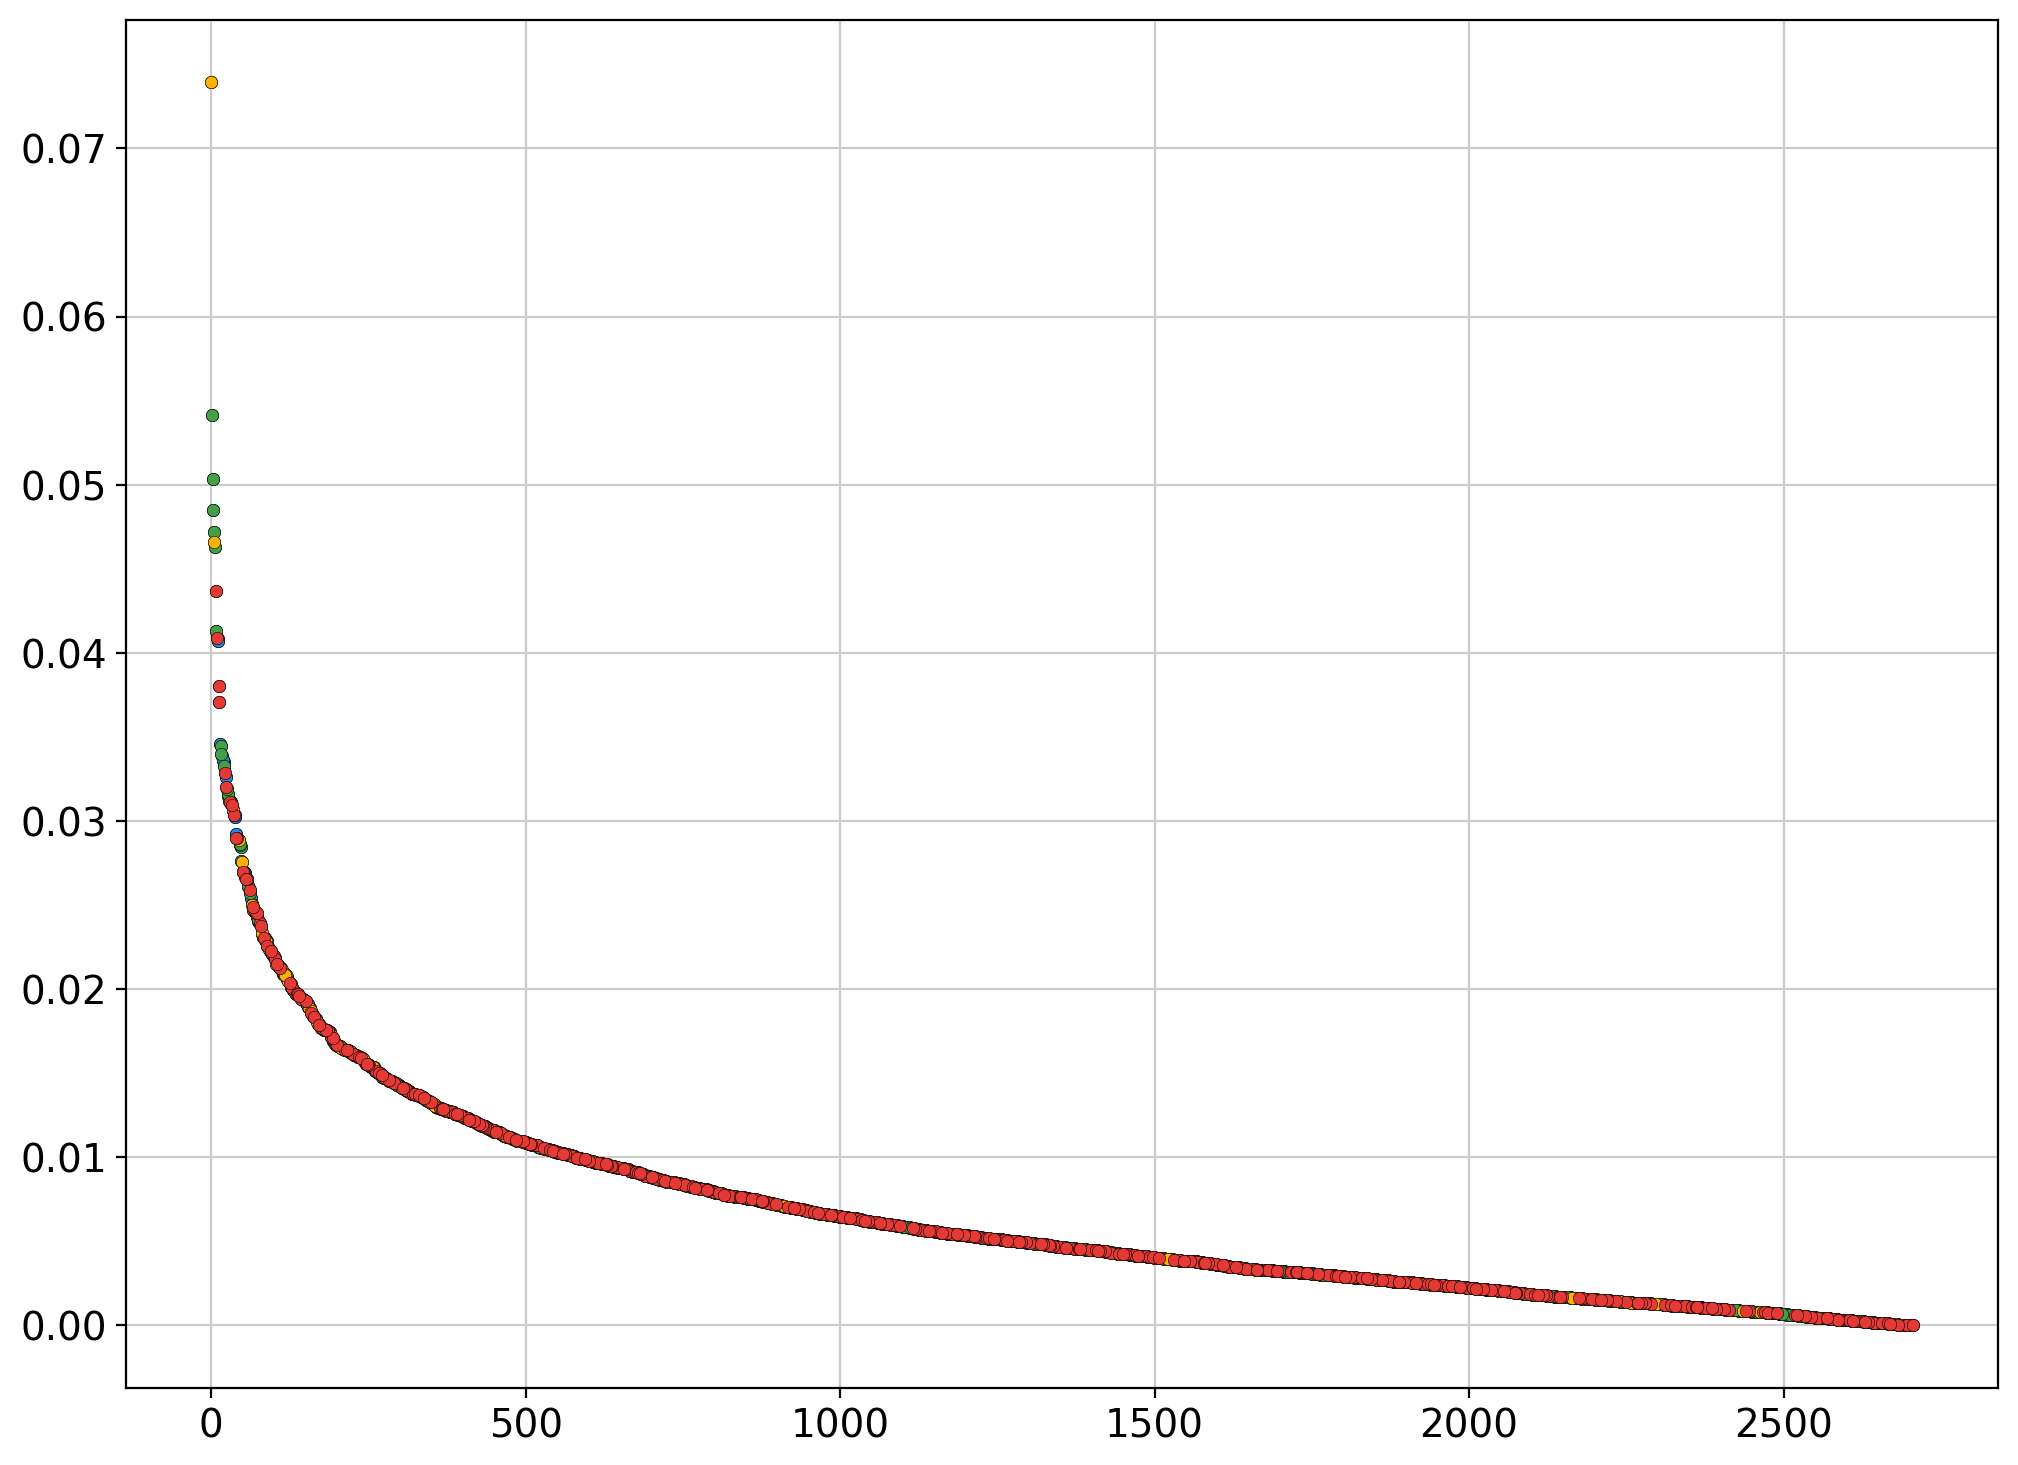

In [21]:
plt.figure(figsize=(12,9))
plt.scatter(x=feature_importance_df['Rank'], y=feature_importance_df['importance'], c='grey', 
            s=20, edgecolor='black', linewidth=0.2)
plt.scatter(x=feature_importance_df.loc[filter_unique_up_degs,'Rank'], y=feature_importance_df.loc[filter_unique_up_degs,'importance'], c='#1E88E5', 
            s=20, edgecolor='black', linewidth=0.2)
plt.scatter(x=feature_importance_df.loc[filter_unique_down_degs,'Rank'], y=feature_importance_df.loc[filter_unique_down_degs,'importance'], c='#43A047', 
            s=20, edgecolor='black', linewidth=0.2)
plt.scatter(x=feature_importance_df.loc[filter_common_down_degs,'Rank'], y=feature_importance_df.loc[filter_common_down_degs,'importance'], c='#FFB300', 
            s=20, edgecolor='black', linewidth=0.2)
plt.scatter(x=feature_importance_df.loc[filter_common_up_degs,'Rank'], y=feature_importance_df.loc[filter_common_up_degs,'importance'], c='#E53935', 
            s=20, edgecolor='black', linewidth=0.2)

In [22]:
deg_dict = {}
lc_deg_df = pd.read_csv('./file/deg/training_LC_DEGs.tsv', sep='\t', index_col=0)
crc1_deg_df = pd.read_csv('./file/deg/training_CRC1_DEGs.tsv', sep='\t', index_col=0)
crc2_deg_df = pd.read_csv('./file/deg/training_CRC2_DEGs.tsv', sep='\t', index_col=0)
gc_deg_df = pd.read_csv('./file/deg/training_GC_DEGs.tsv', sep='\t', index_col=0)
hcc_deg_df = pd.read_csv('./file/deg/training_HCC_DEGs.tsv', sep='\t', index_col=0)

In [23]:
cut_logfc = 0.5
cut_pval = 1e-5
cut_pct1 = 0.1
filter_lc_deg_df = lc_deg_df[(lc_deg_df['avg_log2FC']>=cut_logfc) & (lc_deg_df['p_val']<cut_pval) & (lc_deg_df['pct.1']>=cut_pct1)]
filter_crc1_deg_df = crc1_deg_df[(crc1_deg_df['avg_log2FC']>=cut_logfc) & (crc1_deg_df['p_val']<cut_pval) & (crc1_deg_df['pct.1']>=cut_pct1)]
filter_crc2_deg_df = crc2_deg_df[(crc2_deg_df['avg_log2FC']>=cut_logfc) & (crc2_deg_df['p_val']<cut_pval) & (crc2_deg_df['pct.1']>=cut_pct1)]
filter_gc_deg_df = gc_deg_df[(gc_deg_df['avg_log2FC']>=cut_logfc) & (gc_deg_df['p_val']<cut_pval) & (gc_deg_df['pct.1']>=cut_pct1)]
filter_hcc_deg_df = hcc_deg_df[(hcc_deg_df['avg_log2FC']>=cut_logfc) & (hcc_deg_df['p_val']<cut_pval) & (hcc_deg_df['pct.1']>=cut_pct1)]

In [24]:
lung_tumor_degs = filter_lc_deg_df[filter_lc_deg_df['cluster']=='Tumor']['gene'].tolist()
lung_normal_degs = filter_lc_deg_df[filter_lc_deg_df['cluster']=='Normal']['gene'].tolist()
crc_tumor_degs1 = filter_crc1_deg_df[filter_crc1_deg_df['cluster']=='Tumor']['gene'].tolist()
crc_normal_degs1 = filter_crc1_deg_df[filter_crc1_deg_df['cluster']=='Normal']['gene'].tolist()
crc_tumor_degs2 = filter_crc2_deg_df[filter_crc2_deg_df['cluster']=='Tumor']['gene'].tolist()
crc_normal_degs2 = filter_crc2_deg_df[filter_crc2_deg_df['cluster']=='Normal']['gene'].tolist()
gc_tumor_degs = filter_gc_deg_df[filter_gc_deg_df['cluster']=='Tumor']['gene'].tolist()
gc_normal_degs = filter_gc_deg_df[filter_gc_deg_df['cluster']=='Normal']['gene'].tolist()
hcc_tumor_degs = filter_hcc_deg_df[filter_hcc_deg_df['cluster']=='Tumor']['gene'].tolist()
hcc_normal_degs = filter_hcc_deg_df[filter_hcc_deg_df['cluster']=='Normal']['gene'].tolist()

In [25]:
crc_tumor_degs = list(set(crc_tumor_degs1+crc_tumor_degs2))
crc_normal_degs = list(set(crc_normal_degs1+crc_normal_degs2))

In [26]:
common_up_deg_count_dict = {}
for gene in filter_common_up_degs:
    count = 0
    if gene in lung_tumor_degs:
        count +=1
    if gene in crc_tumor_degs:
        count +=1
    if gene in gc_tumor_degs:
        count +=1
    if gene in hcc_tumor_degs:
        count +=1
    common_up_deg_count_dict[gene] = count

common_down_deg_count_dict = {}
for gene in filter_common_down_degs:
    count = 0
    if gene in lung_normal_degs:
        count +=1
    if gene in crc_normal_degs:
        count +=1
    if gene in gc_normal_degs:
        count +=1
    if gene in hcc_normal_degs:
        count +=1
    common_down_deg_count_dict[gene] = count

In [27]:
tmp_deg_ls = []
tmp_type_ls = []
for count in [2,3,4]:
    count_up_degs = [x for x,y in common_up_deg_count_dict.items() if y==count]
    tmp_deg_ls.extend(count_up_degs)
    nb_count = len(count_up_degs)
    tmp_type_ls.extend([f'Common upregulated\n(= {count} cancer types, n = {nb_count})']*len(count_up_degs))
    
for count in [2,3,4]:
    count_down_degs = [x for x,y in common_down_deg_count_dict.items() if y==count]
    tmp_deg_ls.extend(count_down_degs)
    nb_count = len(count_down_degs)
    tmp_type_ls.extend([f'Common downregulated\n(= {count} cancer types, n = {nb_count})']*len(count_down_degs))
    
plot_df = pd.DataFrame({'Type':tmp_type_ls}, index=tmp_deg_ls)
plot_df['Importance'] = feature_importance_df.loc[tmp_deg_ls,'importance'].tolist()

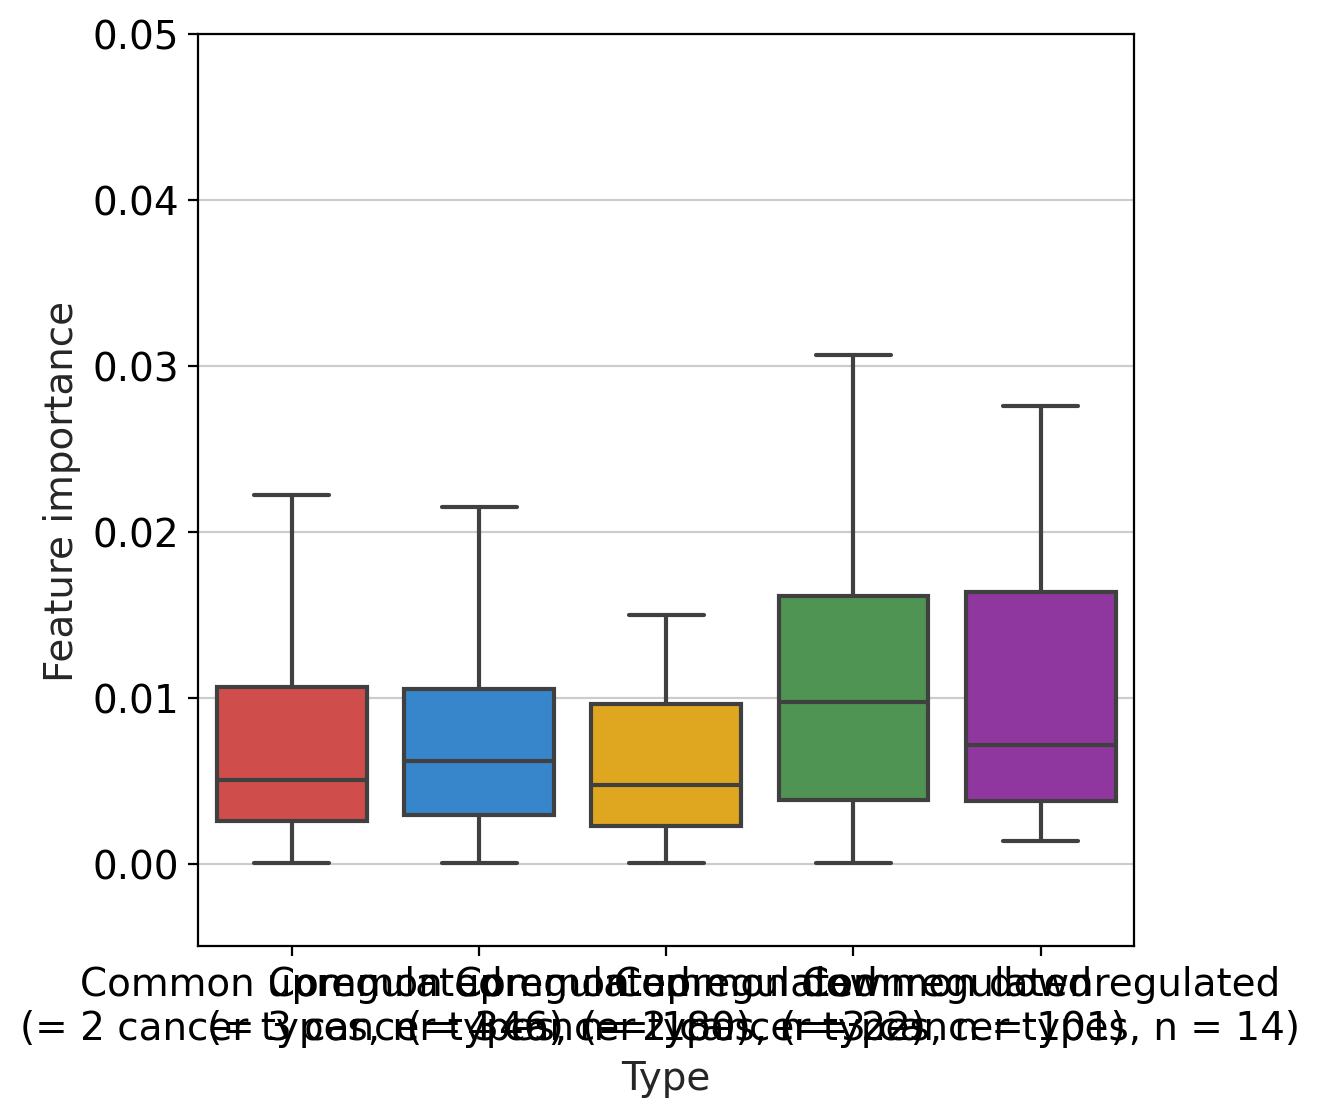

In [28]:
plt.figure(figsize=(6,6))
ax21 = plt.subplot(111)
ax = sns.boxplot(data=plot_df, x="Type", y='Importance', palette=group_colors, ax=ax21, fliersize=0)
_ = plt.xticks(rotation=0)
_ = plt.ylim([-0.005, 0.05])
_ = plt.ylabel('Feature importance')
plt.savefig('./plot/feature_importance_common_DEGs.boxplot.pdf', bbox_inches='tight', dpi=1000)

In [29]:
xx = ['Common upregulated\n(= 2 cancer types, n = 346)',
 'Common upregulated\n(= 3 cancer types, n = 180)',
 'Common upregulated\n(= 4 cancer types, n = 22)']

In [30]:
for a1 in xx:
    for b1 in xx:
        if a1 != b1:
            pvalue = ttest_ind(plot_df.loc[plot_df['Type']==a1,'Importance'], plot_df.loc[plot_df['Type']==b1,'Importance'])[1]
            print(a1, b1, pvalue)

Common upregulated
(= 2 cancer types, n = 346) Common upregulated
(= 3 cancer types, n = 180) 0.6017165508920568
Common upregulated
(= 2 cancer types, n = 346) Common upregulated
(= 4 cancer types, n = 22) 0.8982576204212389
Common upregulated
(= 3 cancer types, n = 180) Common upregulated
(= 2 cancer types, n = 346) 0.6017165508920568
Common upregulated
(= 3 cancer types, n = 180) Common upregulated
(= 4 cancer types, n = 22) 0.7076518593040964
Common upregulated
(= 4 cancer types, n = 22) Common upregulated
(= 2 cancer types, n = 346) 0.8982576204212389
Common upregulated
(= 4 cancer types, n = 22) Common upregulated
(= 3 cancer types, n = 180) 0.7076518593040964


In [31]:
xx = ['Common downregulated\n(= 2 cancer types, n = 101)',
 'Common downregulated\n(= 3 cancer types, n = 14)']

In [32]:
for a1 in xx:
    for b1 in xx:
        if a1 != b1:
            pvalue = ttest_ind(plot_df.loc[plot_df['Type']==a1,'Importance'], plot_df.loc[plot_df['Type']==b1,'Importance'])[1]
            print(a1, b1, pvalue)

Common downregulated
(= 2 cancer types, n = 101) Common downregulated
(= 3 cancer types, n = 14) 0.2552219087479856
Common downregulated
(= 3 cancer types, n = 14) Common downregulated
(= 2 cancer types, n = 101) 0.2552219087479856


In [33]:
meta1_df = pd.read_csv('/mnt/home/qnyu/workspace/scOmics/Dataset/Normal/TabulaSapiens_Epithelial/anno.tsv', index_col=0, sep='\t')
meta2_df = pd.read_csv('/mnt/home/qnyu/workspace/scOmics/Dataset/cellLine/panCancer/Metadata.txt', sep='\t', index_col=0).iloc[1:]

/tmp/ipykernel_45449/1816872587.py:2: DtypeWarning: Columns (4,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  meta2_df = pd.read_csv('/mnt/home/qnyu/workspace/scOmics/Dataset/cellLine/panCancer/Metadata.txt', sep='\t', index_col=0).iloc[1:]


In [34]:
anno_df = pd.read_excel('/mnt/home/qnyu/workspace/scOmics/Dataset/cellLine/panCancer/SubTable_1_add_is_carcinoma_zsy_20230814.xlsx')

In [35]:
meta2_df = meta2_df.loc[meta2_df['Cell_line'].isin(anno_df[anno_df['Cancer_Type_zsy']=='Carcinoma']['Name'].unique())]

In [36]:
cancer_tissue_dict = {
    'Lung Cancer':['Lung'],
    'Head and Neck Cancer': ['Salivary_Gland','Tongue'],
    'Skin Cancer':['Skin'],
    'Breast Cancer':['Mammary'],
    'Esophageal Cancer':[],
    'Ovarian Cancer':[],
    'Pancreatic Cancer':['Pancreas'],
    'Colon/Colorectal Cancer':['Large_Intestine'],
    'Endometrial/Uterine Cancer':['Uterus'],
    'Kidney Cancer':['Kidney'],
    'Liver Cancer':['Liver'],
    'Bladder Cancer':['Bladder'],
    'Gastric Cancer':[],
    'Thyroid Cancer':[],
    'Bile Duct Cancer':[],
    'Prostate Cancer':['Prostate'],
    'Gallbladder Cancer':[]
}

In [37]:
meta_df_ls = []
for cancer in cancer_tissue_dict.keys():
    tissue = '/'.join(cancer_tissue_dict[cancer])
    cancer_cells = meta2_df[meta2_df['Cancer_type']==cancer].index.tolist()
    normal_cells = meta1_df[meta1_df['tissue_in_publication'].isin(cancer_tissue_dict[cancer])].index.tolist()
    cancer_meta_df = pd.DataFrame({'Type':[cancer]*len(cancer_cells)+[tissue]*len(normal_cells), 
                                   'Cancer':[cancer]*len(cancer_cells+normal_cells)}, 
                                  index=cancer_cells+normal_cells)
    meta_df_ls.append(cancer_meta_df)

In [38]:
refine_meta_df = pd.concat(meta_df_ls, axis=0)

In [39]:
test_prefixs = ['cellLineTabula','LC2','LC3','CRC1','CRC2','HCC']

test_adata_dict = {}
for prefix in test_prefixs:
    if prefix == 'cellLineTabula':
        adata = sc.read_h5ad(f'./data/test_{prefix}.h5ad')
        adata.obs = pd.concat([adata.obs,refine_meta_df], axis=1)
        test_adata_dict[prefix] = adata
    else:
        test_adata_dict[prefix] = sc.read_h5ad(f'./data/test_{prefix}.h5ad')

In [40]:
test_method_dict = {}
for prefix in test_prefixs:
    test_other_df = pd.read_csv(f'./file/prediction/other_method.test_{prefix}.tsv', sep='\t', index_col=0)
    test_gene_df = pd.read_csv(f'./file/prediction/test_{prefix}.gene.tsv', sep='\t', index_col=0)
    test_score_df = pd.read_csv(f'./file/prediction/test_{prefix}.score.tsv', sep='\t', index_col=0)
    
    test_gene_df = test_gene_df.rename(columns={'RF':'RandomForest (gene-based)', 'LR':'LogisticRegression (gene-based)', 'XGBoost':'XGBoost (gene-based)'})
    test_score_df = test_score_df.rename(columns={'RF':'RandomForest (signature-based)', 'LR':'LogisticRegression (signature-based)', 'XGBoost':'XGBoost (signature-based)'})
    
    test_method_dict[prefix] = pd.concat([test_gene_df, test_score_df, test_other_df], axis=1)

In [42]:
test_method_dict.keys()

dict_keys(['cellLineTabula', 'LC2', 'LC3', 'CRC1', 'CRC2', 'HCC'])

In [48]:
deg_test_dict = {}

In [49]:
for prefix in test_method_dict.keys():
    all_df = test_method_dict[prefix]['LogisticRegression (gene-based)'].to_frame()
    common_df = pd.read_csv(f'./file/prediction/test_{prefix}.gene.common_degs.tsv', sep='\t', index_col=0)
    unique_df = pd.read_csv(f'./file/prediction/test_{prefix}.gene.unique_degs.tsv', sep='\t', index_col=0)
    
    all_df.columns = ['All DEGs']
    common_df.columns = ['Common DEGs']
    unique_df.columns = ['Unique DEGs']
    label_df = test_adata_dict[prefix].obs['Raw_annotation'].to_frame()
    
    methods = ['All DEGs','Common DEGs','Unique DEGs']
    result_df2 = pd.concat([label_df, all_df, common_df, unique_df], axis=1)
    metric_df = pd.DataFrame(index=['Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV'], columns=methods)
    tumor_result_df = result_df2[result_df2['Raw_annotation']=='Tumor']
    normal_result_df = result_df2[result_df2['Raw_annotation']=='Normal']
    for method in methods:
        method_tumor_result_df = result_df2[result_df2[method]=='Tumor']
        method_normal_result_df = result_df2[result_df2[method]=='Normal']
        metric_df.loc['Accuracy',method] = result_df2[result_df2['Raw_annotation']==result_df2[method]].shape[0] / result_df2.shape[0]
        metric_df.loc['Sensitivity',method] = tumor_result_df[tumor_result_df['Raw_annotation']==tumor_result_df[method]].shape[0] / tumor_result_df.shape[0] if tumor_result_df.shape[0]!=0 else np.nan
        metric_df.loc['Specificity',method] = normal_result_df[normal_result_df['Raw_annotation']==normal_result_df[method]].shape[0] / normal_result_df.shape[0] if normal_result_df.shape[0]!=0 else np.nan
        metric_df.loc['Balanced_accuracy',method] = (metric_df.loc['Sensitivity',method]+metric_df.loc['Specificity',method]) / 2
        if method_tumor_result_df.shape[0]==0:
            metric_df.loc['PPV',method] = np.nan
        else:
            metric_df.loc['PPV',method] = method_tumor_result_df[method_tumor_result_df['Raw_annotation']==method_tumor_result_df[method]].shape[0] / method_tumor_result_df.shape[0]
        if method_normal_result_df.shape[0]==0:
            metric_df.loc['NPV',method] = np.nan
        else:
            metric_df.loc['NPV',method] = method_normal_result_df[method_normal_result_df['Raw_annotation']==method_normal_result_df[method]].shape[0] / method_normal_result_df.shape[0]
    metric_df = metric_df.applymap(float)

    df_ls = []
    for method in methods:
        if method == 'All DEGs':
            pred_df = pd.read_csv(f'./file/proba/scMalignantFinder/test_{prefix}', index_col=0)['Tumor'].to_frame()
        elif method == 'Common DEGs':
            pred_df = pd.read_csv(f'./file/proba/scMalignantFinder/deg/test_{prefix}.common', index_col=0)['Tumor'].to_frame()
        elif method == 'Unique DEGs':
            pred_df = pd.read_csv(f'./file/proba/scMalignantFinder/deg/test_{prefix}.uniuqe', index_col=0)['Tumor'].to_frame()
        pred_df.columns = [method]
        pred_df.index = range(pred_df.shape[0])
        df_ls.append(pred_df)

    combine_pred_df = pd.concat(df_ls, axis=1)

    combine_pred_df['label'] = test_adata_dict[prefix].obs['Raw_annotation'].map(label_dict).tolist()

    auc_dict = {}
    for method in methods:
        # print(method, roc_auc_score(combine_pred_df['label'].values, combine_pred_df[method].values))
        auc_dict[method] = roc_auc_score(combine_pred_df['label'].values, combine_pred_df[method].values)

    tmp_metric_df = metric_df.T

    tmp_metric_df['AUROC'] = tmp_metric_df.index.map(auc_dict)
    metric_df = tmp_metric_df.T.loc[['AUROC','Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV']]
    if prefix == 'cellLineTabula':
        metric_df = metric_df.loc[['Sensitivity','Specificity']]
    
    deg_test_dict[prefix] = metric_df

In [50]:
other_test_prefixs = []
with open('/mnt/home/qnyu/workspace/scOmics/Dataset/Pancancer_2023_Nature/file/run_model.sh') as f:
    for line in f:
        other_test_prefixs.append(line.strip().split(' ')[2].split('.h5ad')[0])
other_test_prefixs.sort()
other_test_prefixs.remove('Data_Izar2020_Ovarian.10X.tpm_10x')

In [51]:
other_test_dict = {}
other_test_adata_dict = {}
for prefix in other_test_prefixs:
    prefix
    adata = sc.read_h5ad(f'/mnt/home/qnyu/workspace/scOmics/Dataset/Pancancer_2023_Nature/file/{prefix}.h5ad')
    adata.obs['Raw_annotation'] = adata.obs['cell_type'].map(lambda x: 'Tumor' if x=='Malignant' else 'Normal')
    adata.obs['Raw_annotation'] = pd.Categorical(adata.obs['Raw_annotation'])
    common_df = pd.read_csv(f'/mnt/home/qnyu/workspace/scOmics/Dataset/Pancancer_2023_Nature/file/{prefix}.gene.common_degs.tsv', sep='\t', index_col=0)
    unique_df = pd.read_csv(f'/mnt/home/qnyu/workspace/scOmics/Dataset/Pancancer_2023_Nature/file/{prefix}.gene.unique_degs.tsv', sep='\t', index_col=0)
    model_pred_df = pd.read_csv(f'/mnt/home/qnyu/workspace/scOmics/Dataset/Pancancer_2023_Nature/file/{prefix}.gene.tsv', sep='\t', index_col=0)
    all_df = model_pred_df['LR'].to_frame()
    all_df.columns = ['All DEGs']
    common_df.columns = ['Common DEGs']
    unique_df.columns = ['Unique DEGs']
    label_df = adata.obs['Raw_annotation'].to_frame()
    
    methods = ['All DEGs','Common DEGs','Unique DEGs']
    result_df2 = pd.concat([label_df, all_df, common_df, unique_df], axis=1)
    other_test_dict[prefix] = result_df2
    other_test_adata_dict[prefix] = adata

In [52]:
tissue_dict = {
    'Kidney':[x for x in other_test_prefixs if re.search('Kidney',x)],
    'Head and Neck':[x for x in other_test_prefixs if re.search('Head_and_Neck',x)],
    'Prostate':[x for x in other_test_prefixs if re.search('Prostate',x)],
    'Breast':[x for x in other_test_prefixs if re.search('Breast',x)],
    'Ovarian':[x for x in other_test_prefixs if re.search('Ovarian',x)],
    'Pancreas':[x for x in other_test_prefixs if re.search('Pancreas',x)],
}

In [53]:
for tissue in tissue_dict.keys():
    result_df2 = pd.concat([other_test_dict[x] for x in tissue_dict[tissue]])
    methods = ['All DEGs','Common DEGs','Unique DEGs']
    metric_df = pd.DataFrame(index=['Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV'], columns=methods)
    tumor_result_df = result_df2[result_df2['Raw_annotation']=='Tumor']
    normal_result_df = result_df2[result_df2['Raw_annotation']=='Normal']
    for method in methods:
        method_tumor_result_df = result_df2[result_df2[method]=='Tumor']
        method_normal_result_df = result_df2[result_df2[method]=='Normal']
        metric_df.loc['Accuracy',method] = result_df2[result_df2['Raw_annotation']==result_df2[method]].shape[0] / result_df2.shape[0]
        metric_df.loc['Sensitivity',method] = tumor_result_df[tumor_result_df['Raw_annotation']==tumor_result_df[method]].shape[0] / tumor_result_df.shape[0] if tumor_result_df.shape[0]!=0 else np.nan
        metric_df.loc['Specificity',method] = normal_result_df[normal_result_df['Raw_annotation']==normal_result_df[method]].shape[0] / normal_result_df.shape[0] if normal_result_df.shape[0]!=0 else np.nan
        metric_df.loc['Balanced_accuracy',method] = (metric_df.loc['Sensitivity',method]+metric_df.loc['Specificity',method]) / 2
        if method_tumor_result_df.shape[0]==0:
            metric_df.loc['PPV',method] = np.nan
        else:
            metric_df.loc['PPV',method] = method_tumor_result_df[method_tumor_result_df['Raw_annotation']==method_tumor_result_df[method]].shape[0] / method_tumor_result_df.shape[0]
        if method_normal_result_df.shape[0]==0:
            metric_df.loc['NPV',method] = np.nan
        else:
            metric_df.loc['NPV',method] = method_normal_result_df[method_normal_result_df['Raw_annotation']==method_normal_result_df[method]].shape[0] / method_normal_result_df.shape[0]
    metric_df = metric_df.applymap(float)
    
    df_ls = []
    for method in methods:
        if method == 'All DEGs':
            tmp_ls = []
            for x in tissue_dict[tissue]:
                tmp_pred_df = pd.read_csv(f'./file/proba/scMalignantFinder/{x}', index_col=0)['Tumor'].to_frame()
                tmp_ls.append(tmp_pred_df)
            pred_df = pd.concat(tmp_ls)
            pred_df.columns = [method]
            pred_df.index = range(pred_df.shape[0])
            df_ls.append(pred_df)
        elif method == 'Common DEGs':
            tmp_ls = []
            for x in tissue_dict[tissue]:
                tmp_pred_df = pd.read_csv(f'./file/proba/scMalignantFinder/deg/{x}.common', index_col=0)['Tumor'].to_frame()
                tmp_ls.append(tmp_pred_df)
            pred_df = pd.concat(tmp_ls)
            pred_df.columns = [method]
            pred_df.index = range(pred_df.shape[0])
            df_ls.append(pred_df)
        elif method == 'Unique DEGs':
            tmp_ls = []
            for x in tissue_dict[tissue]:
                tmp_pred_df = pd.read_csv(f'./file/proba/scMalignantFinder/deg/{x}.uniuqe', index_col=0)['Tumor'].to_frame()
                tmp_ls.append(tmp_pred_df)
            pred_df = pd.concat(tmp_ls)
            pred_df.columns = [method]
            pred_df.index = range(pred_df.shape[0])
            df_ls.append(pred_df)

    combine_pred_df = pd.concat(df_ls, axis=1)

    combine_pred_df['label'] = pd.concat([other_test_adata_dict[x].obs['Raw_annotation'].to_frame() for x in tissue_dict[tissue]])['Raw_annotation'].map(label_dict).tolist()

    auc_dict = {}
    for method in methods:
        # print(method, roc_auc_score(combine_pred_df['label'].values, combine_pred_df[method].values))
        auc_dict[method] = roc_auc_score(combine_pred_df['label'].values, combine_pred_df[method].values)

    tmp_metric_df = metric_df.T

    tmp_metric_df['AUROC'] = tmp_metric_df.index.map(auc_dict)
    metric_df = tmp_metric_df.T.loc[['AUROC','Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV']]
    
    
    deg_test_dict[tissue] = metric_df

In [54]:
df_ls = []
for prefix, metric_df in deg_test_dict.items():
    metric_df['Metric'] = metric_df.index.tolist()
    df_ls.append(pd.melt(metric_df, id_vars=['Metric'], value_vars=methods))

In [55]:
concat_metric_df = pd.concat(df_ls)

In [56]:
pairs = [('All DEGs', 'Common DEGs'),('Common DEGs', 'Unique DEGs'),('All DEGs', 'Unique DEGs')]

/mnt/home/qnyu/miniconda3/envs/ai/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


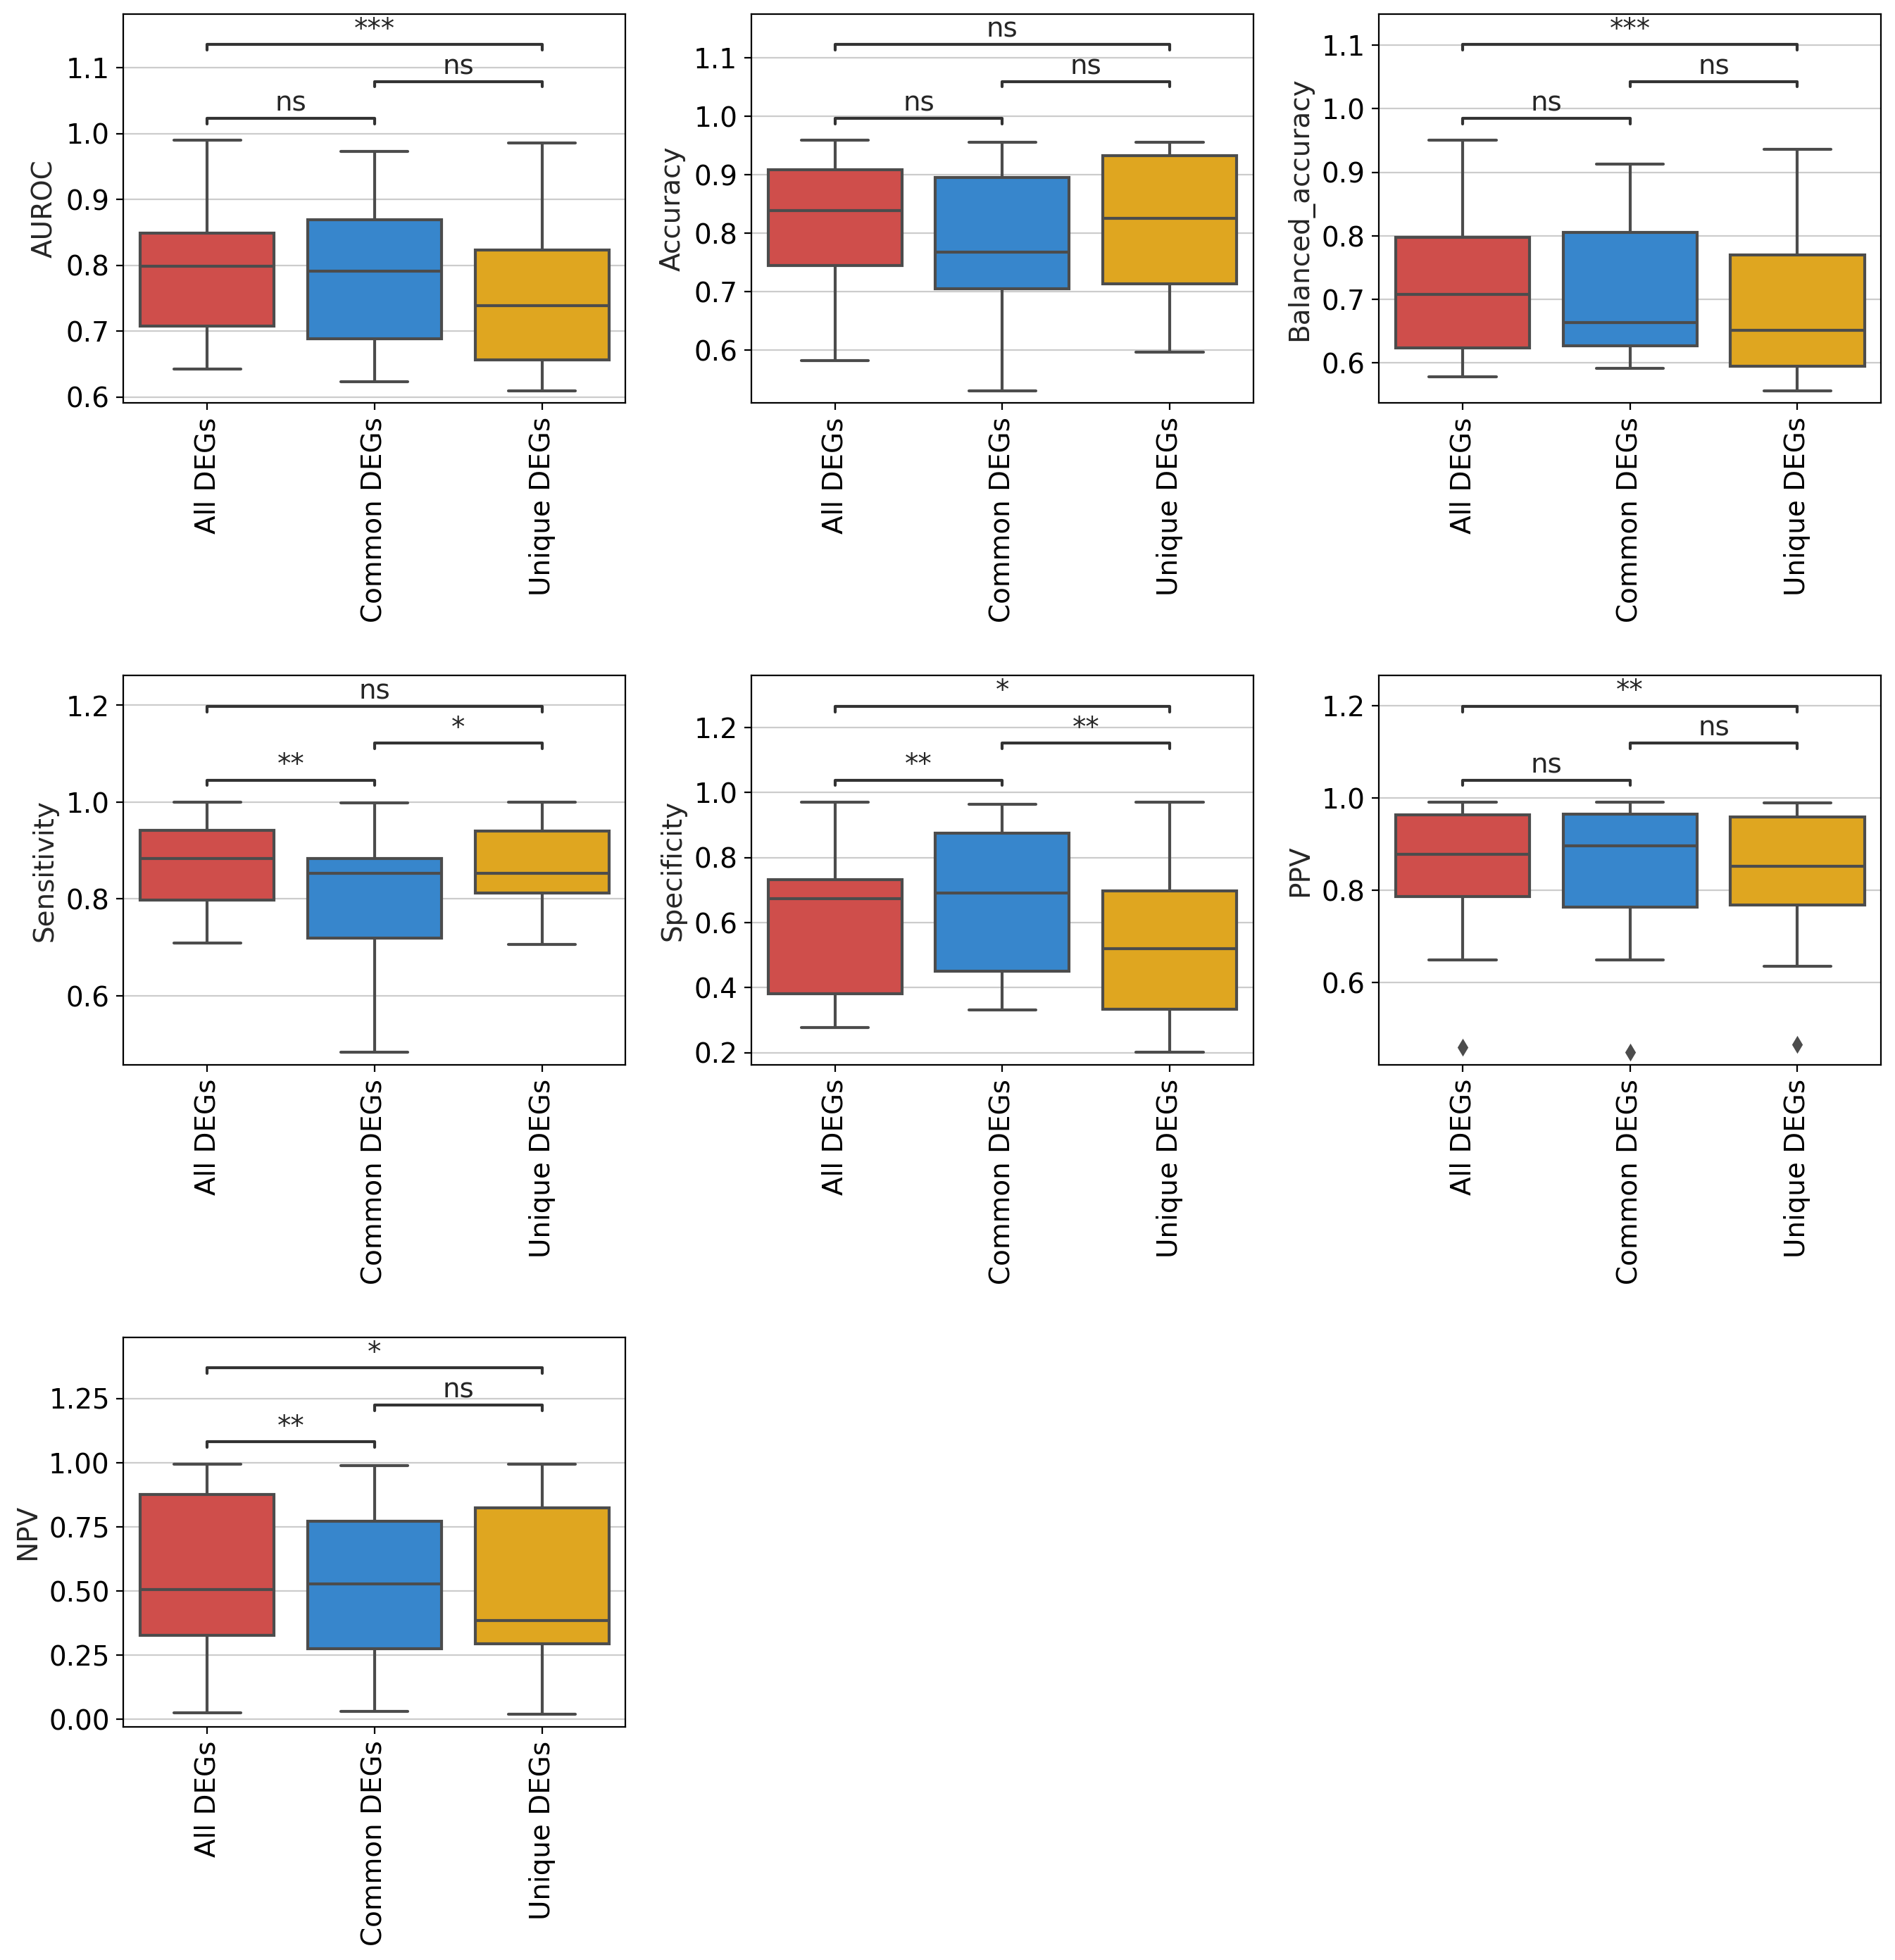

In [57]:
plt.figure(figsize=(16,16))
count = 1

for metric in metric_df.index:
    plot_df = concat_metric_df[concat_metric_df['Metric']==metric]
    plot_df.columns = ['Metric','Method',metric]
    
    ax21 = plt.subplot(3,3,count)
    ax = sns.boxplot(data=plot_df, x="Method", y=metric, palette=group_colors, ax=ax21)
    # ax = sns.swarmplot(data=plot_df, x="Method", y="Specificity", hue="Tissue", palette=group_colors)
    _ = plt.xticks(rotation=90)
    _ = plt.xlabel('')
    annot = Annotator(ax, pairs, data=plot_df, x="Method", y=metric, hide_non_significant=True)
    annot.configure(test='Wilcoxon', text_format='star', verbose=0)
    annot.apply_test()
    annot.annotate()
    count += 1
    _ = plt.xlabel('')
plt.subplots_adjust(wspace=0.25, hspace=0.7)

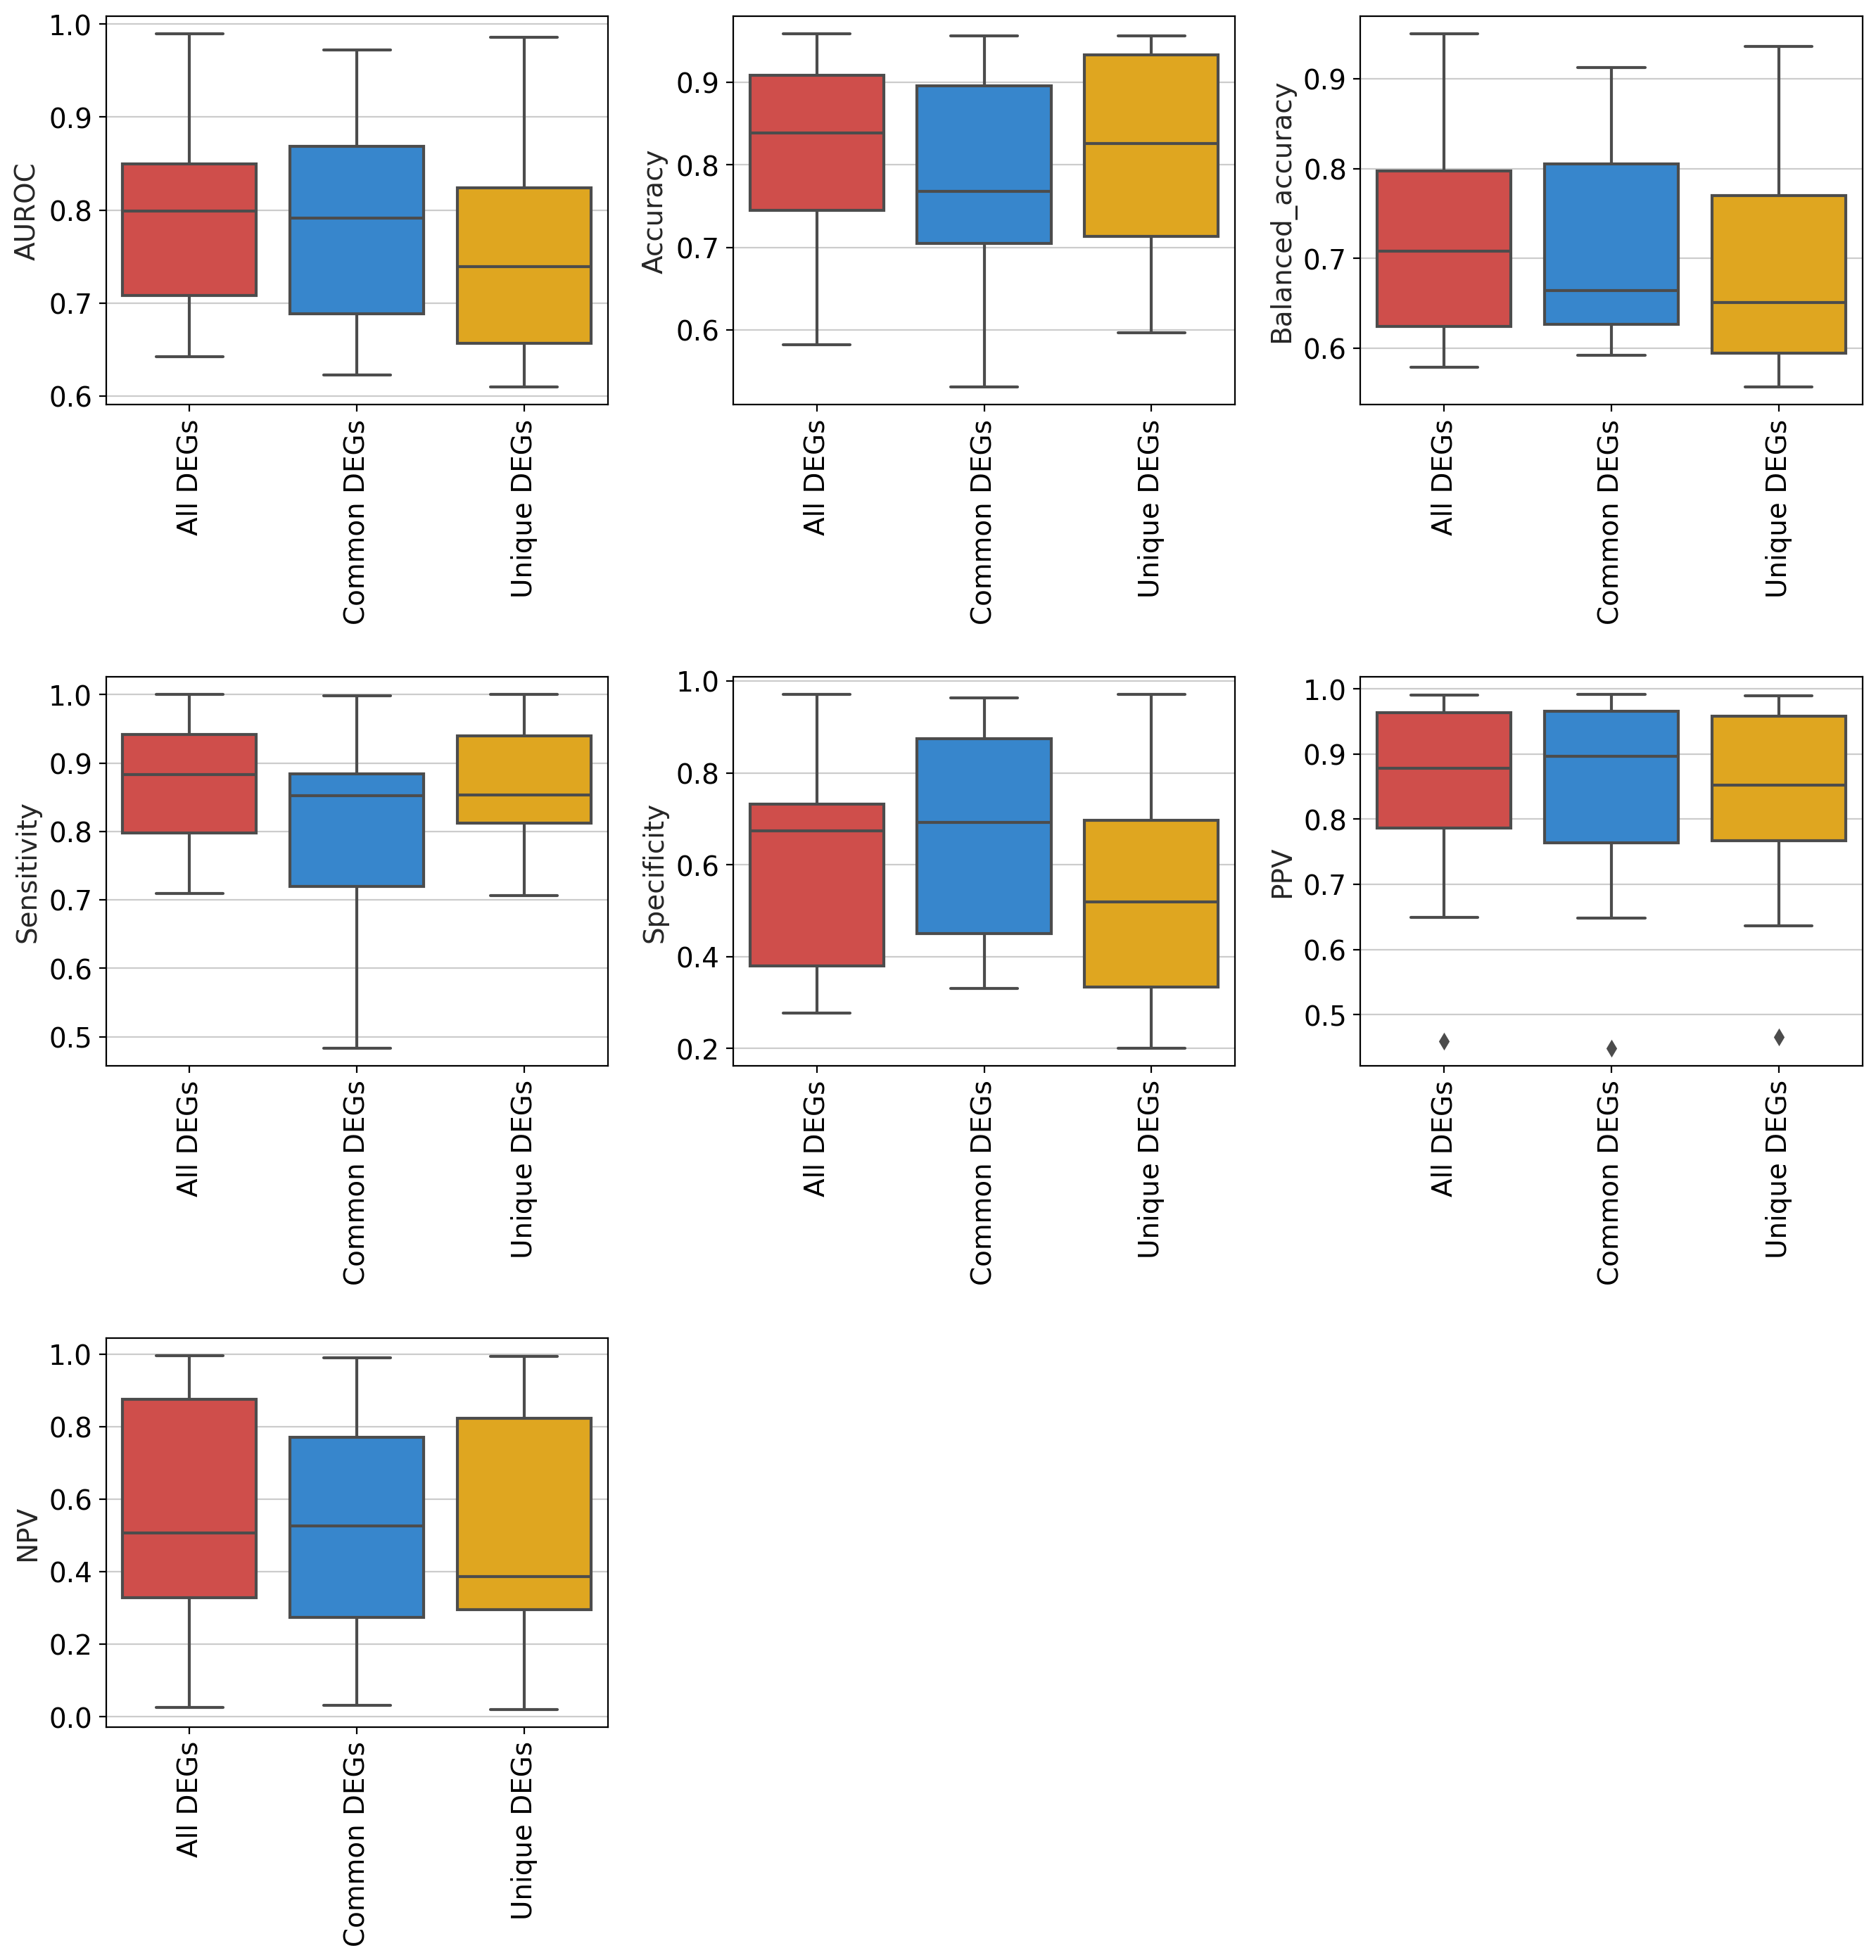

In [58]:
plt.figure(figsize=(16,16))
count = 1

for metric in metric_df.index:
    plot_df = concat_metric_df[concat_metric_df['Metric']==metric]
    plot_df.columns = ['Metric','Method',metric]
    
    ax21 = plt.subplot(3,3,count)
    ax = sns.boxplot(data=plot_df, x="Method", y=metric, palette=group_colors, ax=ax21)
    # ax = sns.swarmplot(data=plot_df, x="Method", y="Specificity", hue="Tissue", palette=group_colors)
    _ = plt.xticks(rotation=90)
    _ = plt.xlabel('')
    # annot = Annotator(ax, pairs, data=plot_df, x="Method", y=metric, hide_non_significant=True)
    # annot.configure(test='Wilcoxon', text_format='star', verbose=0)
    # annot.apply_test()
    # annot.annotate()
    count += 1
    # _ = plt.xlabel('')
plt.subplots_adjust(wspace=0.25, hspace=0.7)
plt.savefig('./plot/metric_common_unique_DEGs.boxplot.pdf', bbox_inches='tight')

In [59]:
metric = 'Sensitivity'

In [60]:
plot_df = concat_metric_df[concat_metric_df['Metric']==metric]

In [61]:
for method in methods:
    print(method, plot_df[plot_df['variable']==method]['value'].mean())

All DEGs 0.8734722485327372
Common DEGs 0.8002101408029879
Unique DEGs 0.8624177288806459


In [62]:
metric = 'PPV'

In [63]:
plot_df = concat_metric_df[concat_metric_df['Metric']==metric]

In [64]:
for method in methods:
    print(method, plot_df[plot_df['variable']==method]['value'].mean())

All DEGs 0.8396781181266056
Common DEGs 0.8418410703191409
Unique DEGs 0.824752373638633


In [65]:
meta1_df = pd.read_csv('/mnt/home/qnyu/workspace/scOmics/Dataset/Normal/TabulaSapiens_Epithelial/anno.tsv', index_col=0, sep='\t')
meta2_df = pd.read_csv('/mnt/home/qnyu/workspace/scOmics/Dataset/cellLine/panCancer/Metadata.txt', sep='\t', index_col=0).iloc[1:]

/tmp/ipykernel_45449/1816872587.py:2: DtypeWarning: Columns (4,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  meta2_df = pd.read_csv('/mnt/home/qnyu/workspace/scOmics/Dataset/cellLine/panCancer/Metadata.txt', sep='\t', index_col=0).iloc[1:]


In [66]:
anno_df = pd.read_excel('/mnt/home/qnyu/workspace/scOmics/Dataset/cellLine/panCancer/SubTable_1_add_is_carcinoma_zsy_20230814.xlsx')

In [67]:
meta2_df = meta2_df.loc[meta2_df['Cell_line'].isin(anno_df[anno_df['Cancer_Type_zsy']=='Carcinoma']['Name'].unique())]

In [68]:
cancer_tissue_dict = {
    'Lung Cancer':['Lung'],
    'Head and Neck Cancer': ['Salivary_Gland','Tongue'],
    'Skin Cancer':['Skin'],
    'Breast Cancer':['Mammary'],
    'Esophageal Cancer':[],
    'Ovarian Cancer':[],
    'Pancreatic Cancer':['Pancreas'],
    'Colon/Colorectal Cancer':['Large_Intestine'],
    'Endometrial/Uterine Cancer':['Uterus'],
    'Kidney Cancer':['Kidney'],
    'Liver Cancer':['Liver'],
    'Bladder Cancer':['Bladder'],
    'Gastric Cancer':[],
    'Thyroid Cancer':[],
    'Bile Duct Cancer':[],
    'Prostate Cancer':['Prostate'],
    'Gallbladder Cancer':[]
}

In [69]:
meta_df_ls = []
for cancer in cancer_tissue_dict.keys():
    tissue = '/'.join(cancer_tissue_dict[cancer])
    cancer_cells = meta2_df[meta2_df['Cancer_type']==cancer].index.tolist()
    normal_cells = meta1_df[meta1_df['tissue_in_publication'].isin(cancer_tissue_dict[cancer])].index.tolist()
    cancer_meta_df = pd.DataFrame({'Type':[cancer]*len(cancer_cells)+[tissue]*len(normal_cells), 
                                   'Cancer':[cancer]*len(cancer_cells+normal_cells)}, 
                                  index=cancer_cells+normal_cells)
    meta_df_ls.append(cancer_meta_df)

In [70]:
refine_meta_df = pd.concat(meta_df_ls, axis=0)

In [75]:
test_prefixs = ['cellLineTabula','LC2','LC3','CRC1','CRC2','HCC']

test_adata_dict = {}
for prefix in test_prefixs:
    if prefix == 'cellLineTabula':
        adata = sc.read_h5ad(f'./data/test_{prefix}.h5ad')
        adata.obs = pd.concat([adata.obs,refine_meta_df], axis=1)
        test_adata_dict[prefix] = adata
    else:
        test_adata_dict[prefix] = sc.read_h5ad(f'./data/test_{prefix}.h5ad')

In [76]:
top_counts = list(range(10,1000,10))+list(range(1000,2750,50))+[2707]

In [77]:
test_metric_dict = {}
for prefix in test_prefixs:
    label_df = test_adata_dict[prefix].obs['Raw_annotation'].to_frame()
    methods = []
    df_ls = []
    for count in top_counts:
        infile = f'./file/prediction/top_feature/test_{prefix}.top{count}.tsv'
        test_df = pd.read_csv(infile, sep='\t', index_col=0)
        infile = f'./file/proba/scMalignantFinder/top_feature/test_{prefix}.top{count}.tsv'
        test_df['Tumor'] = pd.read_csv(infile, sep='\t', index_col=0)['Tumor'].tolist()
        test_df.columns = [str(count), str(count)+'-proba']
        methods.append(count)
        df_ls.append(test_df)

    test_metric_dict[prefix] = pd.concat([label_df,pd.concat(df_ls, axis=1)], axis=1)

In [78]:
other_test_prefixs = []
with open('/mnt/home/qnyu/workspace/scOmics/Dataset/Pancancer_2023_Nature/file/run_model.sh') as f:
    for line in f:
        other_test_prefixs.append(line.strip().split(' ')[2].split('.h5ad')[0])
other_test_prefixs.sort()
other_test_prefixs.remove('Data_Izar2020_Ovarian.10X.tpm_10x')

In [79]:
tissue_dict = {
    'Kidney':[x for x in other_test_prefixs if re.search('Kidney',x)],
    'Head and Neck':[x for x in other_test_prefixs if re.search('Head_and_Neck',x)],
    'Prostate':[x for x in other_test_prefixs if re.search('Prostate',x)],
    'Breast':[x for x in other_test_prefixs if re.search('Breast',x)],
    'Ovarian':[x for x in other_test_prefixs if re.search('Ovarian',x)],
    'Pancreas':[x for x in other_test_prefixs if re.search('Pancreas',x)],
}

In [80]:
for tissue in tissue_dict.keys():
    tissue_prefixs = tissue_dict[tissue]
    
    label_ls = []
    for prefix in tissue_prefixs:
        adata = sc.read_h5ad(f'/mnt/home/qnyu/workspace/scOmics/Dataset/Pancancer_2023_Nature/file/{prefix}.h5ad')
        adata.obs['Raw_annotation'] = adata.obs['cell_type'].map(lambda x: 'Tumor' if x=='Malignant' else 'Normal')
        label_ls.append(adata.obs['Raw_annotation'].to_frame())
    label_df = pd.concat(label_ls)
    
    tmp_ls = []
    for prefix in tissue_prefixs:
        df_ls = []
        for count in top_counts:
            infile = f'./file/prediction/top_feature/{prefix}.top{count}.tsv'
            test_df = pd.read_csv(infile, sep='\t', index_col=0)
            infile = f'./file/proba/scMalignantFinder/top_feature/{prefix}.top{count}.tsv'
            test_df['Tumor'] = pd.read_csv(infile, sep='\t', index_col=0)['Tumor'].tolist()
            test_df.columns = [str(count), str(count)+'-proba']
            df_ls.append(test_df)

        tmp_df = pd.concat(df_ls, axis=1)
        tmp_ls.append(tmp_df)
    
    test_metric_dict[tissue] = pd.concat([label_df,pd.concat(tmp_ls)], axis=1)

In [81]:
metric_dict = {}
for prefix in test_metric_dict.keys():
    result_df2 = test_metric_dict[prefix]
    
    metric_df = pd.DataFrame(index=['AUROC','Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV'], columns=[str(x) for x in methods])
    tumor_result_df = result_df2[result_df2['Raw_annotation']=='Tumor']
    normal_result_df = result_df2[result_df2['Raw_annotation']=='Normal']
    for method in methods:
        method = str(method)
        method_tumor_result_df = result_df2[result_df2[method]=='Tumor']
        method_normal_result_df = result_df2[result_df2[method]=='Normal']
        metric_df.loc['AUROC',method] = roc_auc_score(result_df2['Raw_annotation'].map(label_dict).values, result_df2[method+'-proba'].values)
        metric_df.loc['Accuracy',method] = result_df2[result_df2['Raw_annotation']==result_df2[method]].shape[0] / result_df2.shape[0]
        metric_df.loc['Sensitivity',method] = tumor_result_df[tumor_result_df['Raw_annotation']==tumor_result_df[method]].shape[0] / tumor_result_df.shape[0]
        metric_df.loc['Specificity',method] = normal_result_df[normal_result_df['Raw_annotation']==normal_result_df[method]].shape[0] / normal_result_df.shape[0]
        metric_df.loc['Balanced_accuracy',method] = (metric_df.loc['Sensitivity',method]+metric_df.loc['Specificity',method]) / 2
        if method_tumor_result_df.shape[0]==0:
            metric_df.loc['PPV',method] = np.nan
        else:
            metric_df.loc['PPV',method] = method_tumor_result_df[method_tumor_result_df['Raw_annotation']==method_tumor_result_df[method]].shape[0] / method_tumor_result_df.shape[0]
        if method_normal_result_df.shape[0]==0:
            metric_df.loc['NPV',method] = np.nan
        else:
            metric_df.loc['NPV',method] = method_normal_result_df[method_normal_result_df['Raw_annotation']==method_normal_result_df[method]].shape[0] / method_normal_result_df.shape[0]
    metric_df = metric_df.applymap(float)
    if prefix == 'cellLineTabula':
        metric_df = metric_df.loc[['Sensitivity','Specificity']]
    metric_dict[prefix] = metric_df

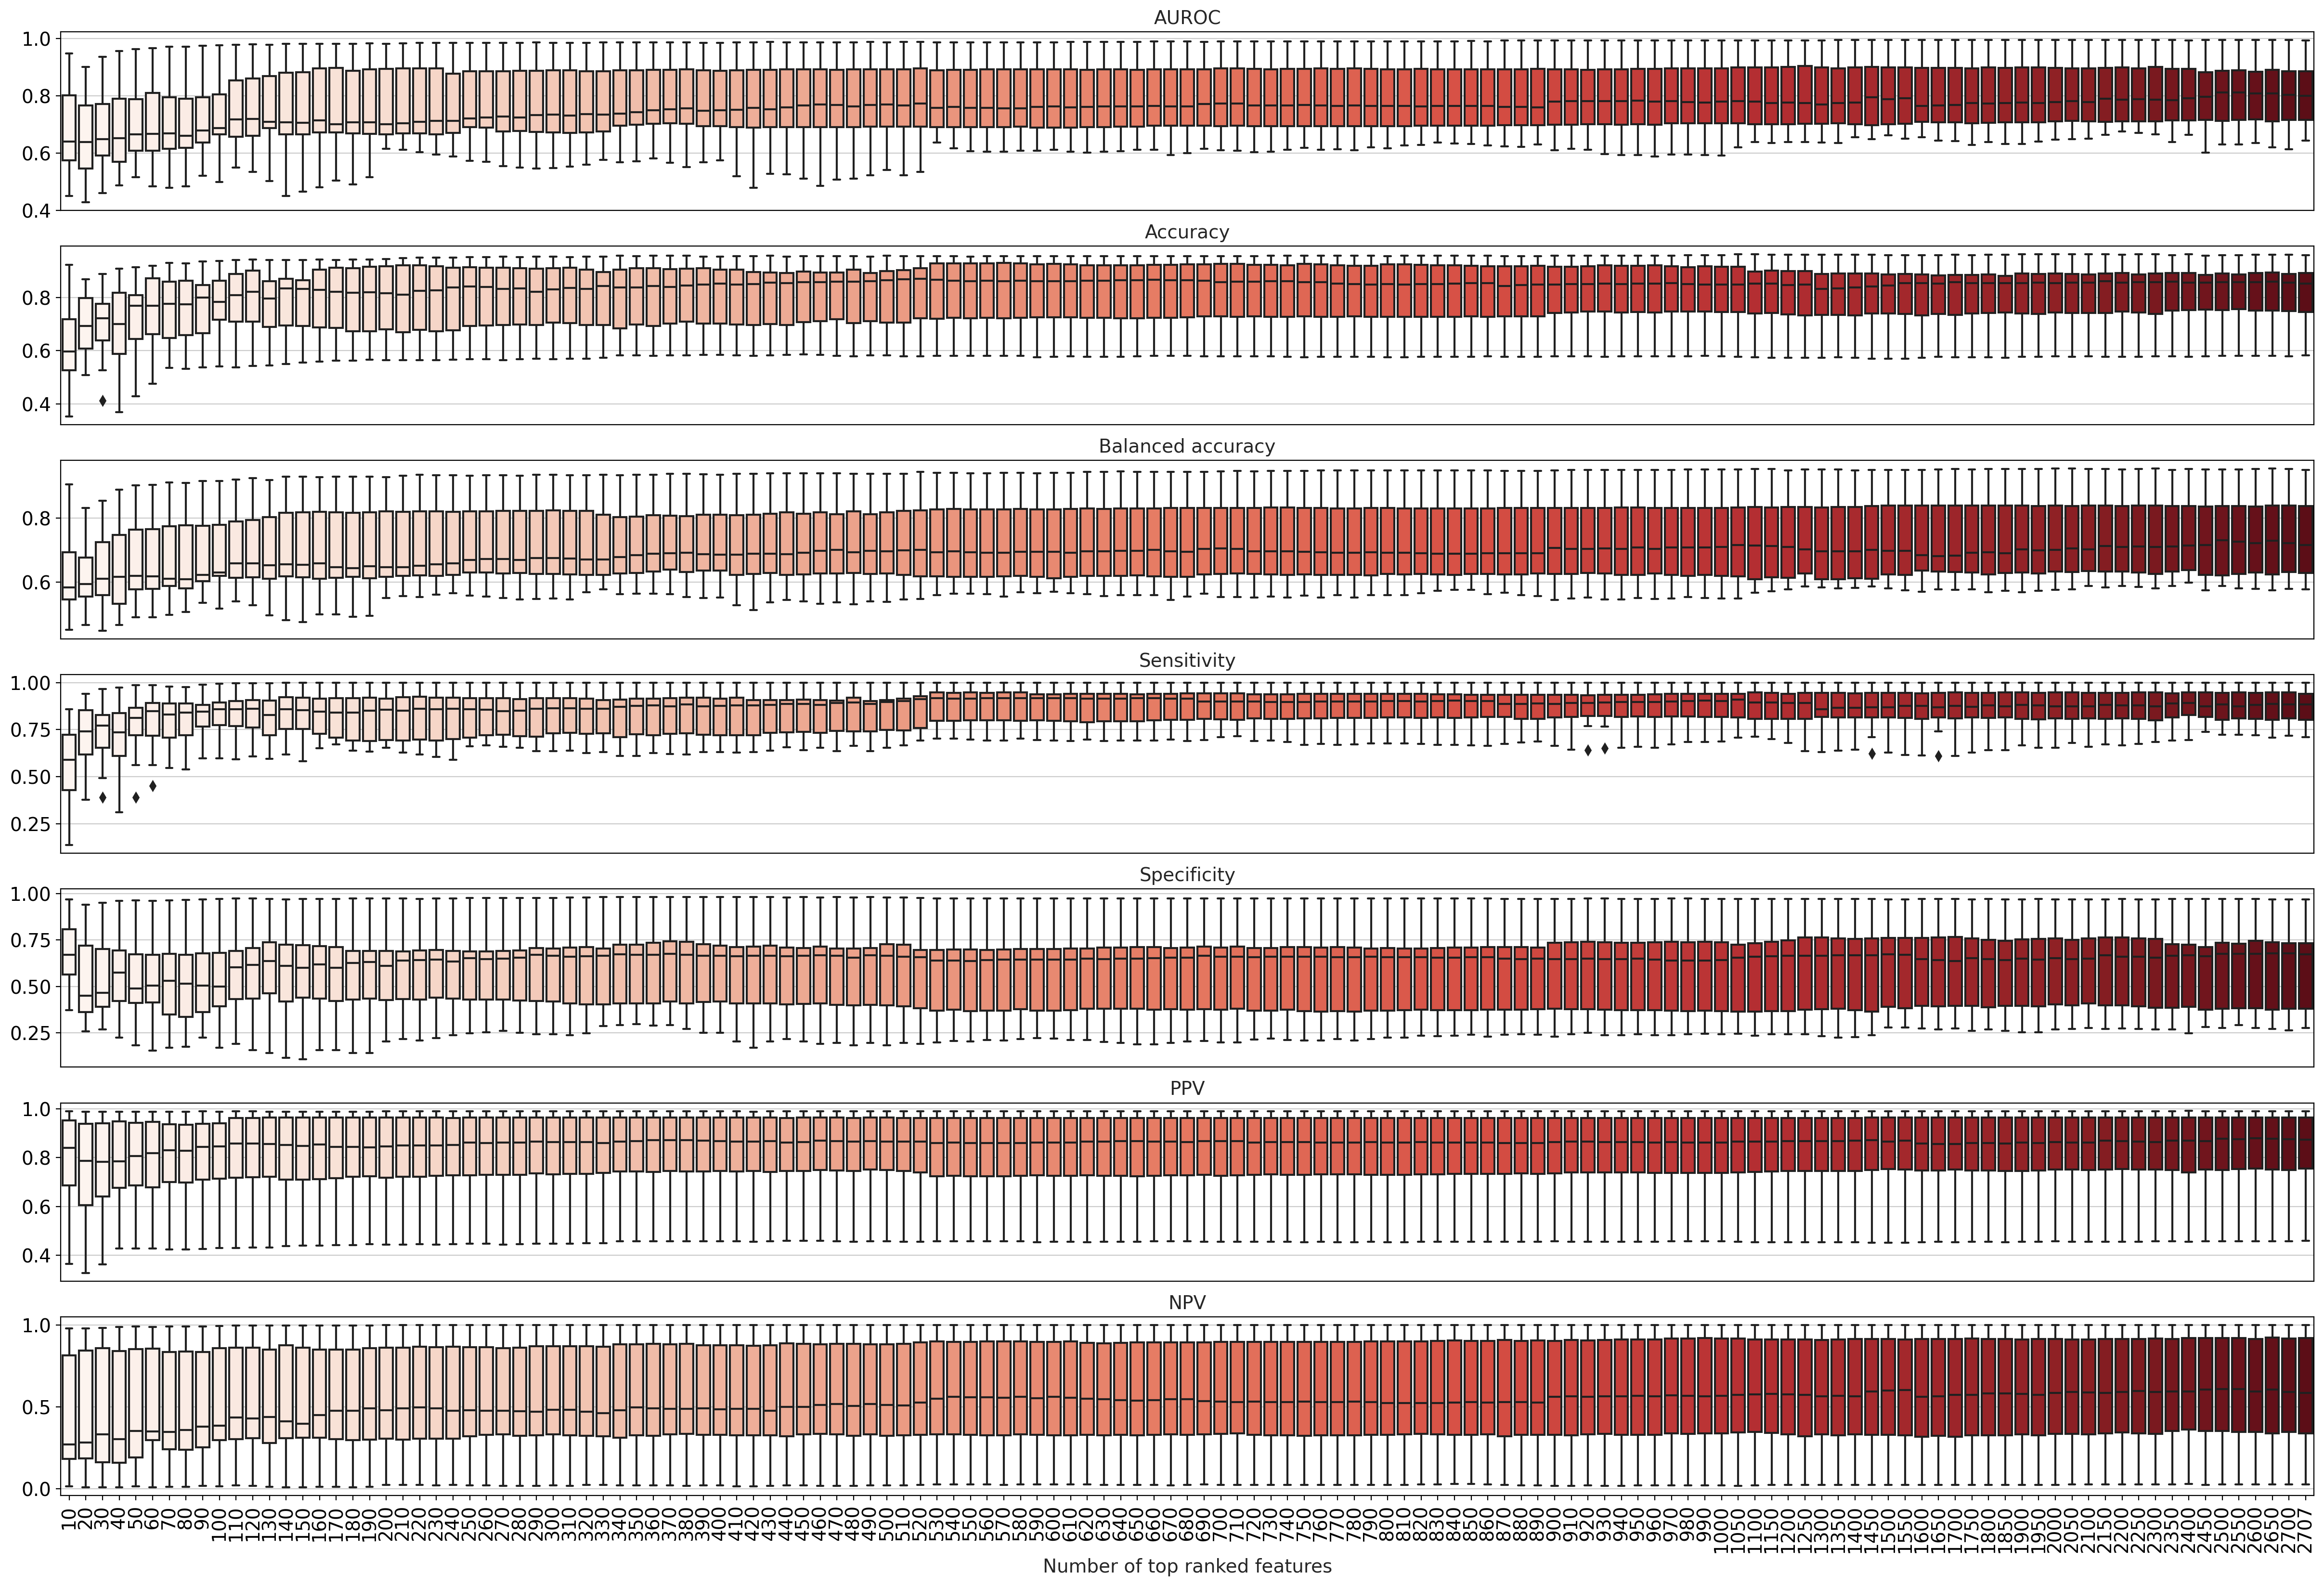

In [85]:
plt.figure(figsize=(30,20))
for count,metric in enumerate(metric_df.index):
    tmp_range_ls = []
    tmp_value_ls = []
    for metric_df in metric_dict.values():
        tmp_range_ls.extend(metric_df.columns.map(int))
        tmp_value_ls.extend(metric_df.loc[metric])
    plot_df = pd.DataFrame({'Number of top ranked features':tmp_range_ls, metric:tmp_value_ls})
    
    ax21 = plt.subplot(7,1,count+1)
    sns.boxplot(x='Number of top ranked features', y=metric, data=plot_df, palette='Reds', ax=ax21)
    if count != 6:
        _ = plt.xticks([])
        _ = plt.xlabel('')
    else:
        _ = plt.xticks(rotation=90)
    _ = plt.ylabel('')
    _ = plt.title(metric.replace('_',' '))
plt.savefig('./plot/metric_top_feature.boxplot.pdf', bbox_inches='tight')

In [88]:
pval_dict = {}
for metric in metric_df.index:
    label_metrics = []
    tmp_metric_dict = {}
    for prefix in test_metric_dict.keys():
        metric_df = metric_dict[prefix]
        label_metrics.append(metric_df.loc[metric].iloc[-1])
        
        for count in metric_df.columns[:-1]:
            if count in tmp_metric_dict:
                tmp_metric_dict[count].append(metric_df.loc[metric,count])
            else:
                tmp_metric_dict[count] = [metric_df.loc[metric,count]]
    pval_ls = []
    for count, tmp_ls in tmp_metric_dict.items():
        pval_ls.append(ttest_rel(tmp_ls,label_metrics,alternative='less')[1])
    pval_dict[metric] = pval_ls

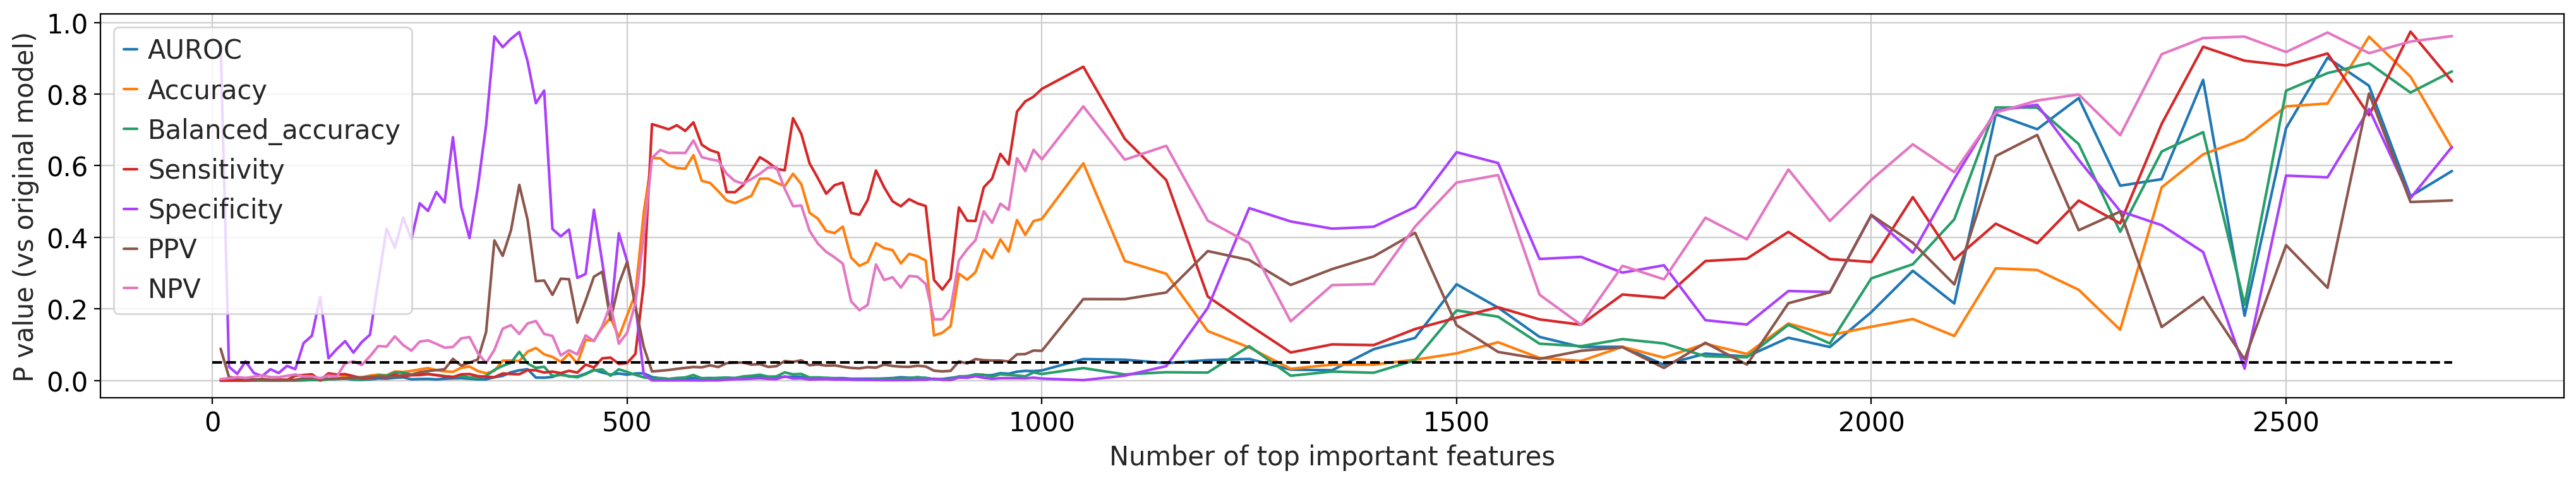

In [101]:
plt.figure(figsize=(25,4))
for metric in metric_df.index:
    plt.plot(metric_df.columns.map(int)[:-1], pval_dict[metric], label=metric)
_ = plt.xticks(fontsize=15)
_ = plt.yticks(fontsize=15)
_ = plt.ylabel('P value (vs original model)', fontsize=15)
_ = plt.xlabel('Number of top important features', fontsize=15)
_ = plt.hlines(y=0.05, xmin=0, xmax=2700, color='black', linestyle='dashed')
_ = plt.legend(loc='best', fontsize=15)
plt.savefig('./plot/metric_top_feature.plot.pdf', bbox_inches='tight')

In [107]:
method_v1 = '1500'
method_v2 = '2707'

In [116]:
tmp_metric_ls = []
tmp_value_ls = []
tmp_method_ls = []
for metric_df in metric_dict.values():
    tmp_metric_ls.extend(metric_df.index)
    tmp_value_ls.extend(metric_df[method_v1].values)
    tmp_method_ls.extend(['1500']*metric_df.shape[0])
    tmp_metric_ls.extend(metric_df.index)
    tmp_value_ls.extend(metric_df[method_v2].values)
    tmp_method_ls.extend(['2707']*metric_df.shape[0])
plot_df = pd.DataFrame({'Method':tmp_method_ls, 'Metric':tmp_metric_ls, 'Value':tmp_value_ls})

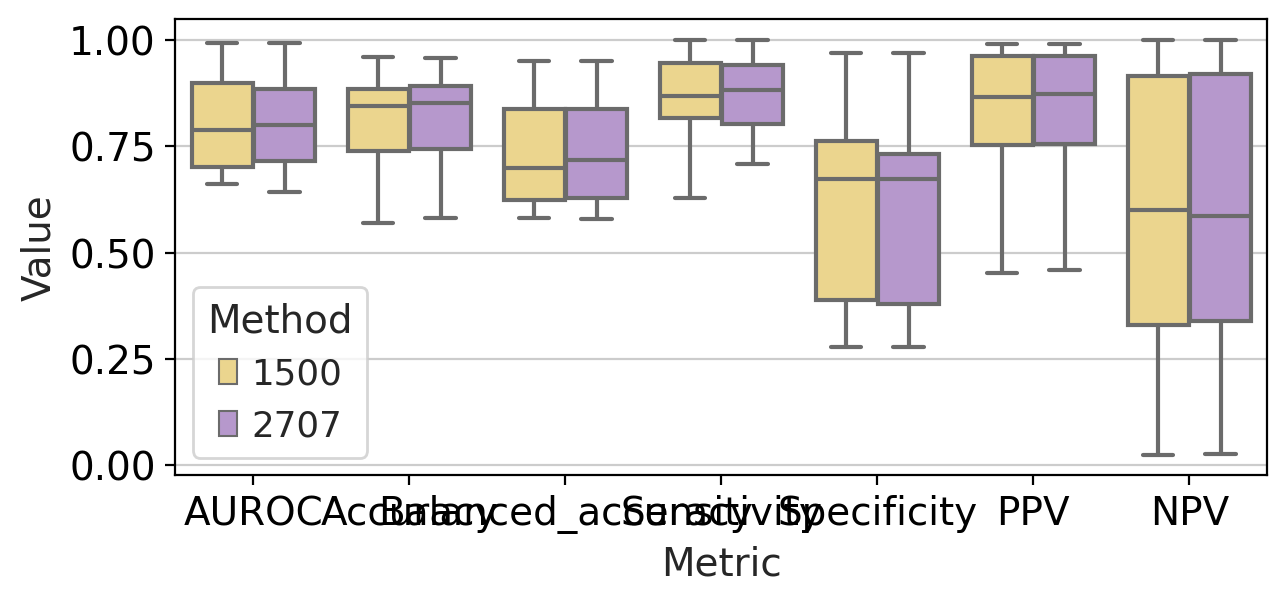

In [128]:
plt.figure(figsize=(7,3))
sns.boxplot(data=plot_df, x="Metric", hue='Method', y='Value', palette=['#fbdd7e','#b790d4'])
plt.savefig('./plot/metric_top_feature_vs_original.boxplot.pdf', bbox_inches='tight')

In [129]:
feature_importance_df = pd.read_csv('./file/feature_importance.LogisticRegression_coefficient.csv', index_col=0).sort_values('importance', ascending=False)

In [130]:
nb_top = 1500
top_features = feature_importance_df.index[:nb_top].tolist()
other_features = feature_importance_df.index[nb_top:].tolist()

In [134]:
with open('./file/deg/up_deg_count_tumor_types.pkl','rb') as f:
    up_deg_count_dict = pickle.load(f)
with open('./file/deg/down_deg_count_tumor_types.pkl','rb') as f:
    down_deg_count_dict = pickle.load(f)

In [135]:
top_up_count_ls = []
top_down_count_ls = []
other_up_count_ls = []
other_down_count_ls = []

for gene in top_features:
    if gene in up_deg_count_dict:
        top_up_count_ls.append(up_deg_count_dict[gene])
    else:
        top_down_count_ls.append(down_deg_count_dict[gene])
        
for gene in other_features:
    if gene in up_deg_count_dict:
        other_up_count_ls.append(up_deg_count_dict[gene])
    else:
        other_down_count_ls.append(down_deg_count_dict[gene])

In [136]:
top_up_count_dict = Counter(top_up_count_ls)
other_up_count_dict = Counter(other_up_count_ls)
top_down_count_dict = Counter(top_down_count_ls)
other_down_count_dict = Counter(other_down_count_ls)

In [137]:
top_up_count_ls = []
top_down_count_ls = []
other_up_count_ls = []
other_down_count_ls = []

for count in [1,2,3,4]:
    if count in top_up_count_dict:
        top_up_count_ls.append(top_up_count_dict[count])
    else:
        top_up_count_ls.append(0)
        
    if count in top_down_count_dict:
        top_down_count_ls.append(top_down_count_dict[count])
    else:
        top_down_count_ls.append(0)
        
    if count in other_up_count_dict:
        other_up_count_ls.append(other_up_count_dict[count])
    else:
        other_up_count_ls.append(0)
        
    if count in top_down_count_dict:
        other_down_count_ls.append(other_down_count_dict[count])
    else:
        other_down_count_ls.append(0)

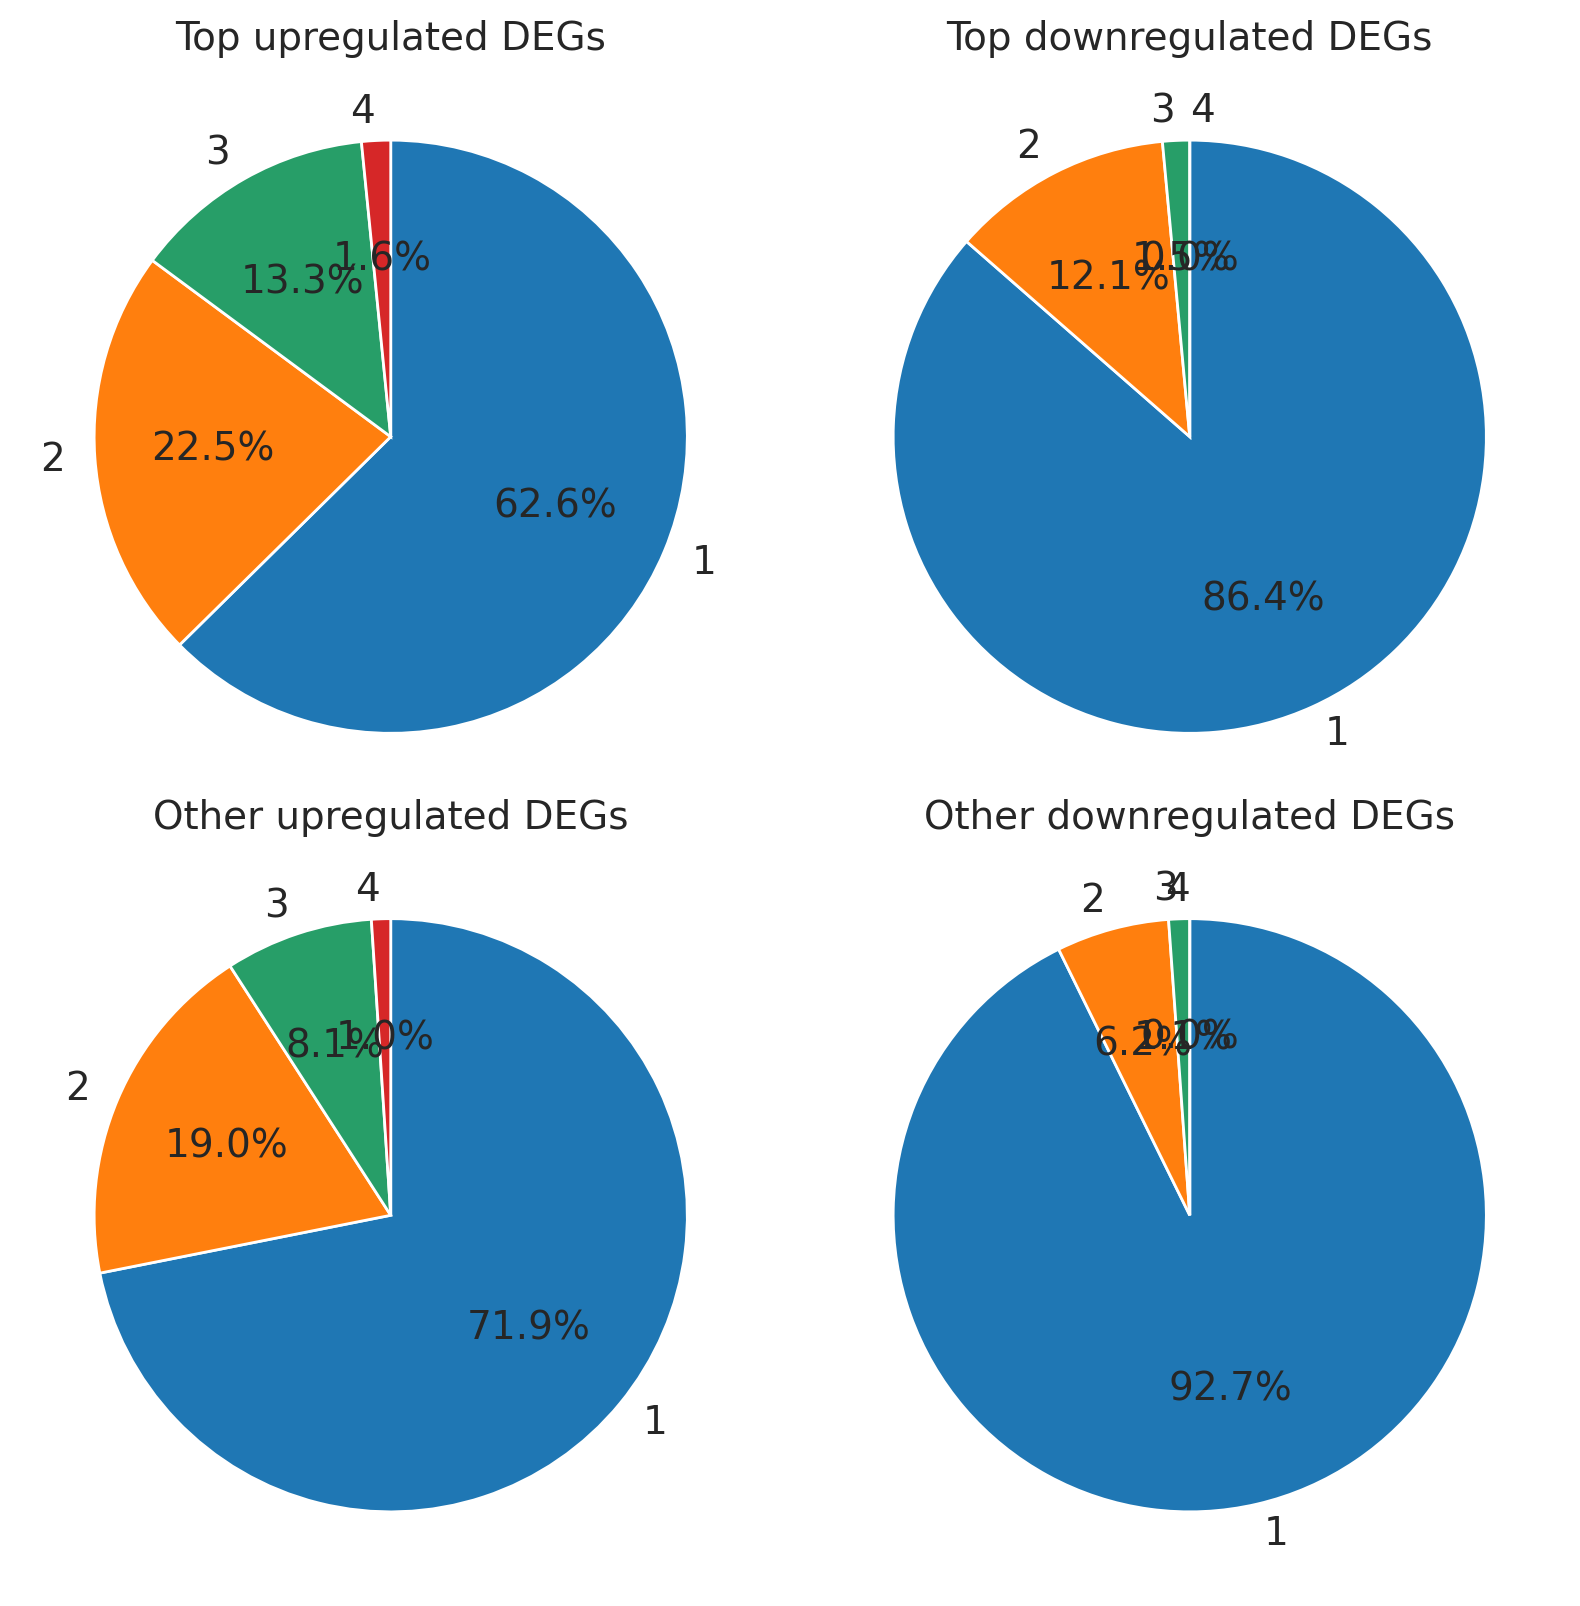

In [138]:
plt.figure(figsize=(10,10))
ax21 = plt.subplot(2,2,1)
_ = ax21.pie(top_up_count_ls, labels=[1,2,3,4], autopct='%1.1f%%', counterclock=False, startangle=90)
_ = ax21.set_title('Top upregulated DEGs')
ax21 = plt.subplot(2,2,2)
_ = ax21.pie(top_down_count_ls, labels=[1,2,3,4], autopct='%1.1f%%', counterclock=False, startangle=90)
_ = ax21.set_title('Top downregulated DEGs')

ax21 = plt.subplot(2,2,3)
_ = ax21.pie(other_up_count_ls, labels=[1,2,3,4], autopct='%1.1f%%', counterclock=False, startangle=90)
_ = ax21.set_title('Other upregulated DEGs')
ax21 = plt.subplot(2,2,4)
_ = ax21.pie(other_down_count_ls, labels=[1,2,3,4], autopct='%1.1f%%', counterclock=False, startangle=90)
_ = ax21.set_title('Other downregulated DEGs')
_ = plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [141]:
top_count_ls = []
other_count_ls = []

for gene in top_features:
    if gene in up_deg_count_dict:
        top_count_ls.append(up_deg_count_dict[gene])
    else:
        top_count_ls.append(down_deg_count_dict[gene])
        
for gene in other_features:
    if gene in up_deg_count_dict:
        other_count_ls.append(up_deg_count_dict[gene])
    else:
        other_count_ls.append(down_deg_count_dict[gene])

In [142]:
top_count_dict = Counter(top_count_ls)
other_count_dict = Counter(other_count_ls)

In [146]:
top_count_dict

Counter({3: 127, 1: 1085, 2: 274, 4: 14})

In [154]:
top_count_ls = []
other_count_ls = []

for count in [1,2,3,4]:
    if count in top_count_dict:
        top_count_ls.append(top_count_dict[count])
    else:
        top_count_ls.append(0)
        
    if count in other_count_dict:
        other_count_ls.append(other_count_dict[count])
    else:
        other_count_ls.append(0)

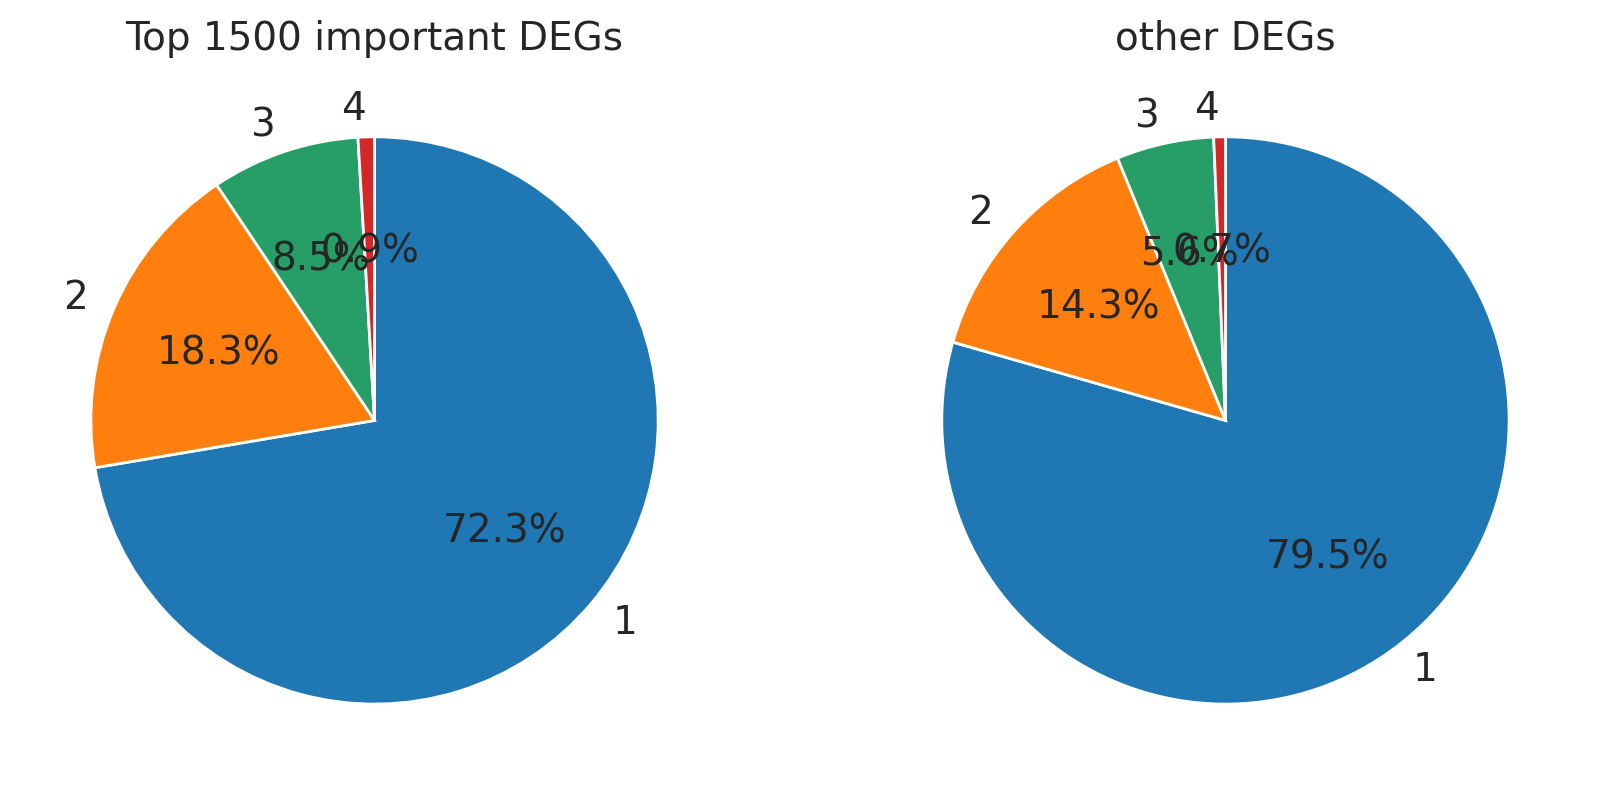

In [156]:
plt.figure(figsize=(10,5))
ax21 = plt.subplot(1,2,1)
_ = ax21.pie(top_count_ls, labels=[1,2,3,4], autopct='%1.1f%%', counterclock=False, startangle=90)
_ = ax21.set_title('Top 1500 important DEGs')
ax21 = plt.subplot(1,2,2)
_ = ax21.pie(other_count_ls, labels=[1,2,3,4], autopct='%1.1f%%', counterclock=False, startangle=90)
_ = ax21.set_title('other DEGs')
plt.savefig('./plot/count_top_feature_vs_other.pie.pdf', bbox_inches='tight')